---

## 0. Descubrimiento de Esquemas de Tablas

Antes de cargar y analizar los datos, es una buena pr√°ctica consultar los esquemas de las tablas directamente en BigQuery para conocer las columnas disponibles y sus tipos de datos. Esto nos ayudar√° a evitar errores de `KeyError` y a comprender la estructura de cada conjunto de datos.

# An√°lisis Exploratorio de Datos (EDA) y Selecci√≥n de Features

Este notebook de BigQuery te guiar√° a trav√©s de un An√°lisis Exploratorio de Datos (EDA) exhaustivo y un proceso de selecci√≥n de features. Utilizaremos los conjuntos de datos proporcionados (`datawave-proyecto-final.census_dataset`, `datawave-proyecto-proyecto-final.gmaps_dataset`, y `datawave-proyecto-final.yelpdataset`) para entender sus caracter√≠sticas, identificar patrones y preparar los datos para el entrenamiento de un modelo. Al final, la justificaci√≥n de la elecci√≥n del modelo y los criterios de desarrollo se basar√°n en las insights obtenidas del EDA.

In [33]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACI√ìN GLOBAL ---
# Define la cantidad de filas a limitar en las consultas de BigQuery.
# Puedes cambiar este valor para cargar m√°s o menos datos para tu EDA.
QUERY_LIMIT = 5000000

# Inicializa clientes de BigQuery para las ubicaciones correctas de tus datasets.
# 'US' es una ubicaci√≥n multiregional que abarca varios datasets en Estados Unidos.
client_us = bigquery.Client(location='US')
# 'us-central1' es una regi√≥n espec√≠fica dentro de Estados Unidos, para el dataset de Yelp.
client_us_central = bigquery.Client(location='us-central1')

def print_table_schema(project_id, dataset_id, table_id, client_obj):
    """Consulta y muestra el esquema (columnas y tipos de datos) de una tabla de BigQuery.
       Recibe un objeto client_obj para manejar diferentes ubicaciones si es necesario."""
    query = f"""
    SELECT column_name, data_type
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.COLUMNS`
    WHERE table_name = '{table_id}'
    ORDER BY ordinal_position
    """
    print(f"\n--- Esquema para {dataset_id}.{table_id} (Ubicaci√≥n del cliente: {client_obj.location}) ---")
    try:
        schema_df = client_obj.query(query).to_dataframe()
        if not schema_df.empty:
            with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                print(schema_df.to_string())
        else:
            print(f"No se encontraron columnas para la tabla '{table_id}'. Por favor, verifica el nombre o si es una tabla de datos real.")
    except Exception as e:
        print(f"Error al consultar el esquema: {e}")

# Consulta los esquemas de las tablas principales que usaremos
# Usa el cliente apropiado para cada dataset seg√∫n las ubicaciones confirmadas

# Tablas del dataset de Censo (Ubicaci√≥n: US)
print_table_schema('datawave-proyecto-final', 'census_dataset', 'Census', client_us)

# Tablas del dataset de Google Maps (Ubicaci√≥n: US)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_relacional', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_types', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_attribute_values', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_category', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_category_relacional', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_hours', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'gmap_sites', client_us)
print_table_schema('datawave-proyecto-final', 'gmaps_dataset', 'review_gmap', client_us)

# Tablas del dataset de Yelp (Ubicaci√≥n: us-central1)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'review_yelp', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_attributes', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_attributes_rel', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_business', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_category', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_category_rel', client_us)
print_table_schema('datawave-proyecto-final', 'yelp_dataset', 'yelp_hours', client_us)


--- Esquema para census_dataset.Census (Ubicaci√≥n del cliente: US) ---
               column_name data_type
0               state_fips     INT64
1              county_fips     INT64
2              county_name    STRING
3  median_household_income   FLOAT64
4        median_home_value   FLOAT64
5         total_population   FLOAT64

--- Esquema para gmaps_dataset.gmap_attribute_relacional (Ubicaci√≥n del cliente: US) ---
          column_name data_type
0             gmap_id    STRING
1   attribute_type_id     INT64
2  attribute_value_id     INT64

--- Esquema para gmaps_dataset.gmap_attribute_types (Ubicaci√≥n del cliente: US) ---
         column_name data_type
0     attribute_type    STRING
1  attribute_type_id     INT64

--- Esquema para gmaps_dataset.gmap_attribute_values (Ubicaci√≥n del cliente: US) ---
          column_name data_type
0     attribute_value    STRING
1  attribute_value_id     INT64

--- Esquema para gmaps_dataset.gmap_category (Ubicaci√≥n del cliente: US) ---
     col

---

## 1. Conexi√≥n a BigQuery y Carga de Datos

Ahora que conocemos los esquemas, cargaremos una muestra de los datos de cada tabla relevante en DataFrames de Pandas para facilitar el an√°lisis. Recordamos que usamos `LIMIT` para una exploraci√≥n inicial que no sobrecargue la memoria. El valor de `LIMIT` es controlado por la variable `QUERY_LIMIT` definida al inicio del script.

**Importante**: Estamos utilizando clientes de BigQuery con las ubicaciones correctas para cada dataset para asegurar el acceso.

In [34]:
# Inicializa clientes para las diferentes ubicaciones de tus datasets.
# La variable QUERY_LIMIT est√° definida globalmente al inicio del script.
client_us = bigquery.Client(location='US')
client_us_central = bigquery.Client(location='us-central1')

# Cargar datos del censo (usando client_us)
query_census = f"""
SELECT *
FROM `datawave-proyecto-final.census_dataset.Census`
LIMIT {QUERY_LIMIT}
"""
census_df = client_us.query(query_census).to_dataframe()

# Cargar datos de Google Maps: gmap_sites (informaci√≥n principal del negocio - usando client_us)
query_gmap_sites = f"""
SELECT *
FROM `datawave-proyecto-final.gmaps_dataset.gmap_sites`
WHERE REGEXP_EXTRACT(address, r',\\s*([A-Z]{{2}})\\s+\\d{{5}},\\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_sites_df = client_us.query(query_gmap_sites).to_dataframe()

# Cargar datos de Google Maps: review_gmap (rese√±as de clientes - usando client_us)
query_review_gmap = f"""
SELECT r.*
FROM `datawave-proyecto-final.gmaps_dataset.review_gmap` r
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON r.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\\s*([A-Z]{{2}})\\s+\\d{{5}},\\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
review_gmap_df = client_us.query(query_review_gmap).to_dataframe()

# Cargar datos de Google Maps: gmap_attribute_relacional (atributos de negocios - usando client_us)
query_gmap_attributes = f"""
SELECT a.*
FROM `datawave-proyecto-final.gmaps_dataset.gmap_attribute_relacional` a
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON a.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\s*([A-Z]{2})\s+\d{5},\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_attributes_df = client_us.query(query_gmap_attributes).to_dataframe()

# Cargar datos de Google Maps: gmap_category_relacional (categor√≠as de negocios - usando client_us)
query_gmap_categories = f"""
SELECT c.*
FROM `datawave-proyecto-final.gmaps_dataset.gmap_category_relacional` c
JOIN `datawave-proyecto-final.gmaps_dataset.gmap_sites` s
  ON c.gmap_id = s.gmap_id
WHERE REGEXP_EXTRACT(s.address, r',\s*([A-Z]{2})\s+\d{5},\s*United States') = 'NJ'
LIMIT {QUERY_LIMIT}
"""
gmap_categories_df = client_us.query(query_gmap_categories).to_dataframe()

# Cargar datos de Yelp: yelp_business (informaci√≥n principal del negocio - usando client_us)
query_yelp_business = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_business`
WHERE LOWER(state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
yelp_business_df = client_us.query(query_yelp_business).to_dataframe()

# Cargar datos de Yelp: review_yelp (rese√±as de clientes - usando client_us)
query_review_yelp = f"""
SELECT r.*
FROM `datawave-proyecto-final.yelpdataset.review_yelp` r
JOIN `datawave-proyecto-final.yelpdataset.yelp_business` b
  ON r.business_id = b.business_id
WHERE LOWER(b.state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
review_yelp_df = client_us.query(query_review_yelp).to_dataframe()

# Cargar datos de Yelp: yelp_attributes_rel (atributos de negocios - usando client_us)
query_yelp_attributes_rel = f"""
SELECT a.*
FROM `datawave-proyecto-final.yelpdataset.yelp_attributes_rel` a
JOIN `datawave-proyecto-final.yelpdataset.yelp_business` b
  ON a.business_id = b.business_id
WHERE LOWER(b.state) = 'nj'
LIMIT {QUERY_LIMIT}
"""
yelp_attributes_rel_df = client_us.query(query_yelp_attributes_rel).to_dataframe()

# Cargar datos de Yelp: yelp_category_rel (categor√≠as de negocios - usando client_us)
query_yelp_category_rel = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_category_rel`
LIMIT {QUERY_LIMIT}
"""
yelp_category_rel_df = client_us.query(query_yelp_category_rel).to_dataframe()

---

## 2. An√°lisis Exploratorio de Datos (EDA)

Realizaremos un EDA para cada conjunto de datos, inspeccionando su estructura, identificando valores faltantes, analizando distribuciones y explorando relaciones entre variables.

### 2.1. `census_dataset.Census`

Este conjunto de datos contiene informaci√≥n demogr√°fica a nivel de condado.

--- census_df ---
Primeras 5 filas:
   state_fips  county_fips                    county_name  \
0          34            1    Atlantic County, New Jersey   
1          34            3      Bergen County, New Jersey   
2          34            5  Burlington County, New Jersey   
3          34            7      Camden County, New Jersey   
4          34            9    Cape May County, New Jersey   

   median_household_income  median_home_value  total_population  
0                  76819.0           272700.0          274704.0  
1                 123715.0           593200.0          954717.0  
2                 105271.0           326700.0          464226.0  
3                  86384.0           262200.0          524042.0  
4                  88046.0           395000.0           95236.0  

Informaci√≥n del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------     

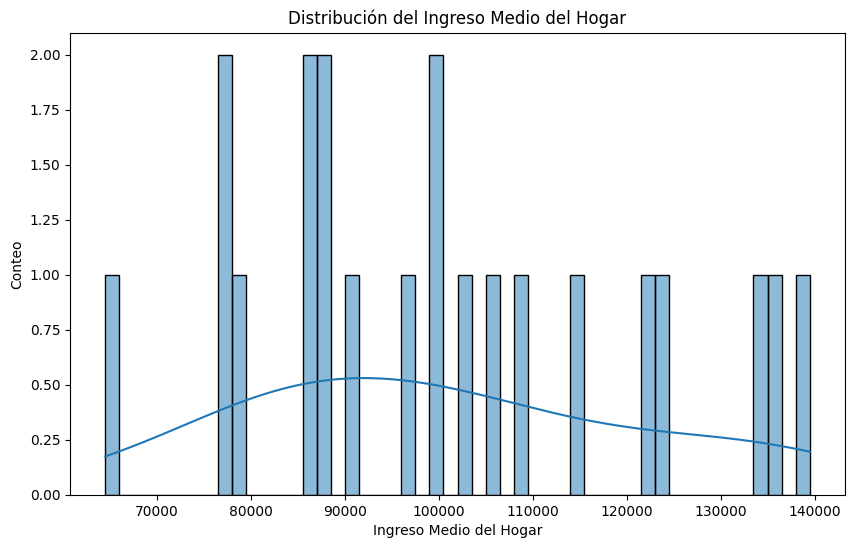

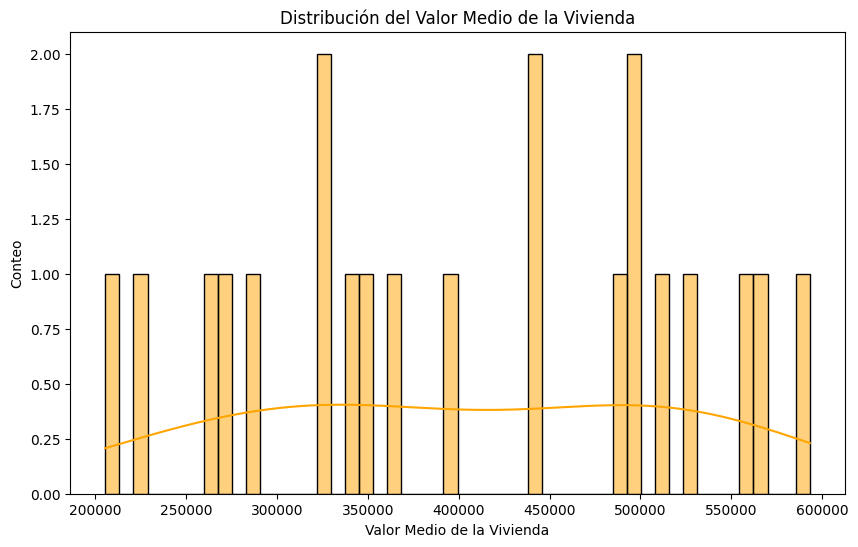

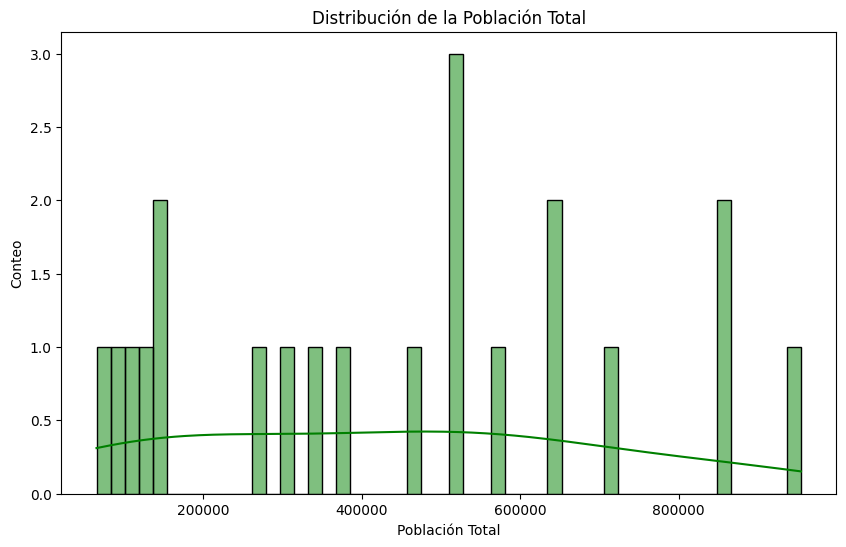

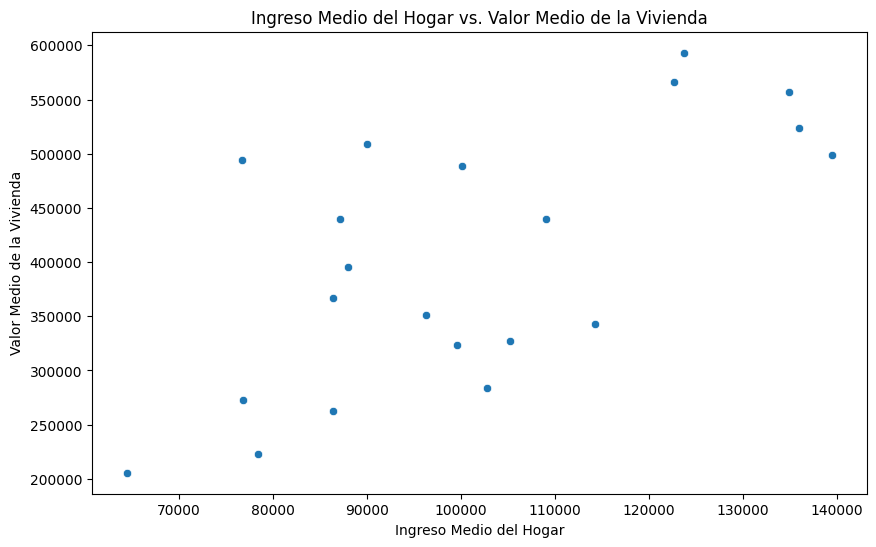

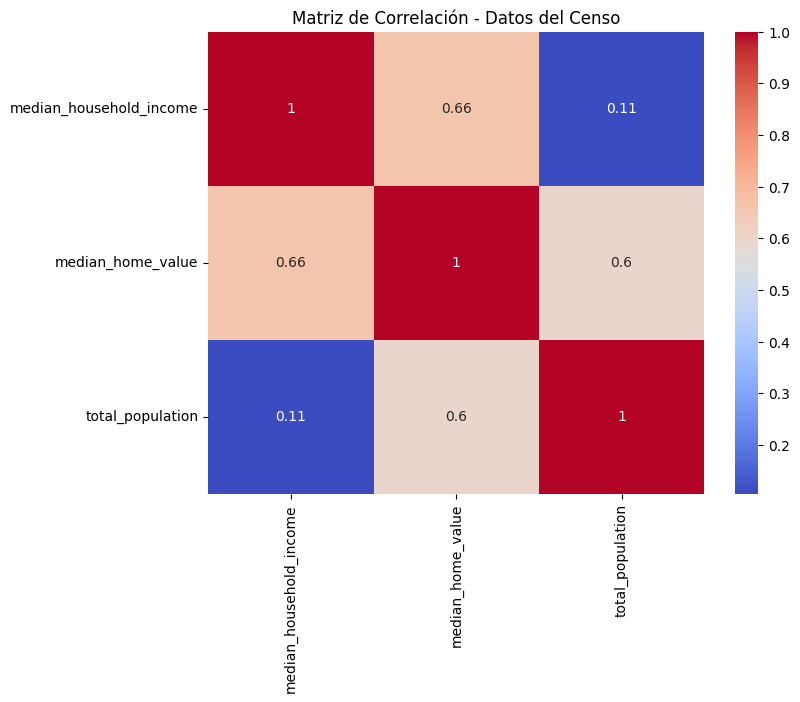

In [35]:
print("--- census_df ---")
print("Primeras 5 filas:")
print(census_df.head())
print("\nInformaci√≥n del DataFrame:")
print(census_df.info())
print("\nEstad√≠sticas descriptivas:")
print(census_df.describe())
print("\nConteo de valores nulos:")
print(census_df.isnull().sum())

# Visualizar la distribuci√≥n del ingreso medio del hogar
plt.figure(figsize=(10, 6))
sns.histplot(census_df['median_household_income'], bins=50, kde=True)
plt.title('Distribuci√≥n del Ingreso Medio del Hogar')
plt.xlabel('Ingreso Medio del Hogar')
plt.ylabel('Conteo')
plt.show()

# Visualizar la distribuci√≥n del valor medio de la vivienda
plt.figure(figsize=(10, 6))
sns.histplot(census_df['median_home_value'], bins=50, kde=True, color='orange')
plt.title('Distribuci√≥n del Valor Medio de la Vivienda')
plt.xlabel('Valor Medio de la Vivienda')
plt.ylabel('Conteo')
plt.show()

# Visualizar la distribuci√≥n de la poblaci√≥n total
plt.figure(figsize=(10, 6))
sns.histplot(census_df['total_population'], bins=50, kde=True, color='green')
plt.title('Distribuci√≥n de la Poblaci√≥n Total')
plt.xlabel('Poblaci√≥n Total')
plt.ylabel('Conteo')
plt.show()

# Relaci√≥n entre ingreso medio del hogar y valor medio de la vivienda
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='median_home_value', data=census_df)
plt.title('Ingreso Medio del Hogar vs. Valor Medio de la Vivienda')
plt.xlabel('Ingreso Medio del Hogar')
plt.ylabel('Valor Medio de la Vivienda')
plt.show()

# Matriz de correlaci√≥n
plt.figure(figsize=(8, 6))
sns.heatmap(census_df[['median_household_income', 'median_home_value', 'total_population']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaci√≥n - Datos del Censo')
plt.show()

**An√°lisis de `census_df`:**
* **`state_fips`** y **`county_fips`**: Son identificadores. `state_fips` parece constante (34, New Jersey), lo que significa que el an√°lisis es a nivel de condado dentro de ese estado. `county_fips` es el identificador √∫nico del condado.
* **`county_name`**: Nombre del condado.
* **`median_household_income`**: Variable num√©rica clave. Su distribuci√≥n es importante para entender la riqueza de los condados.
* **`median_home_value`**: Otra variable num√©rica clave, a menudo correlacionada con el ingreso.
* **`total_population`**: Muestra la densidad demogr√°fica.
* **Valores Nulos**: En este dataset de ejemplo, no hay valores nulos, lo que es ideal.
* **Correlaciones**: Se observar√° la relaci√≥n entre ingreso, valor de la vivienda y poblaci√≥n para entender los factores socioecon√≥micos.

---

### 2.2. `gmaps_dataset`

Este conjunto de datos abarca informaci√≥n de negocios de Google Maps, incluyendo sitios, rese√±as, atributos y categor√≠as.

#### 2.2.1. `gmap_sites_df` (Informaci√≥n principal del negocio)


--- gmap_sites_df ---
Primeras 5 filas:
                                             address  avg_rating  \
0  Blue Cross and Blue Shield, 1427 Wyckoff Rd, W...         1.7   
1  Domino's Pizza, 190 Kearny Ave, Kearny, NJ 070...         3.6   
2  Blimpie America's Sub Shop, 18 S Valley Rd, We...         3.7   
3  BJ's Wholesale Club, 1601 US-22, Watchung, NJ ...         3.7   
4  San Antonio, 206 Monroe St, Passaic, NJ 07055,...         3.8   

                                         description  \
0                                               None   
1  Delivery/carryout chain offering a wide range ...   
2  This counter-serve sandwich chain offers hot, ...   
3  Membership-only retail chain offering bulk gro...   
4                                               None   

                                 gmap_id   latitude  longitude  \
0  0x89c22a28599003e7:0xd907ff9b4b23e398  40.209343 -74.130722   
1  0x89c2546a238e5cab:0x1ce865ccf46913ca  40.757703 -74.152780   
2  0x89c3ab6e44

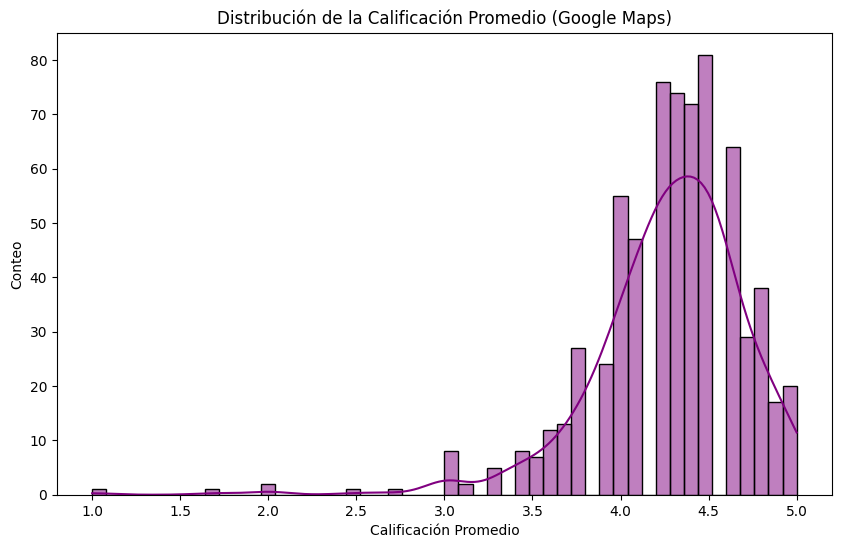

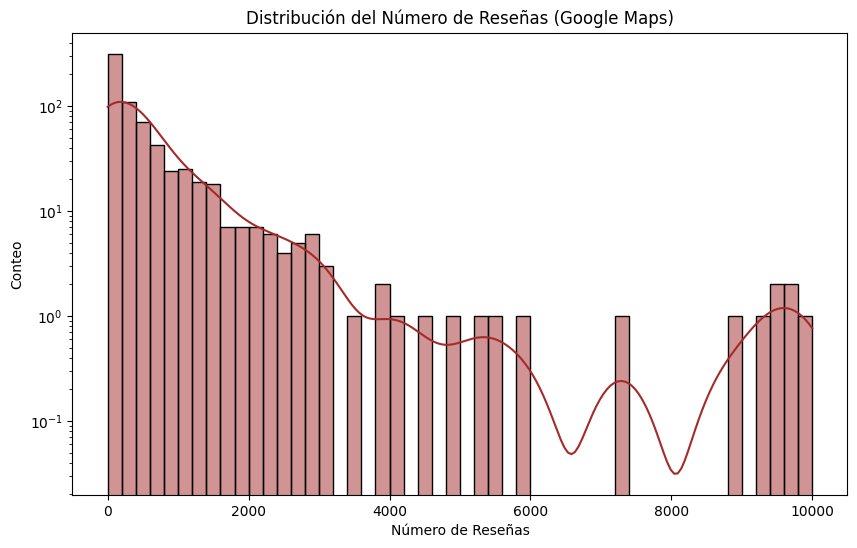

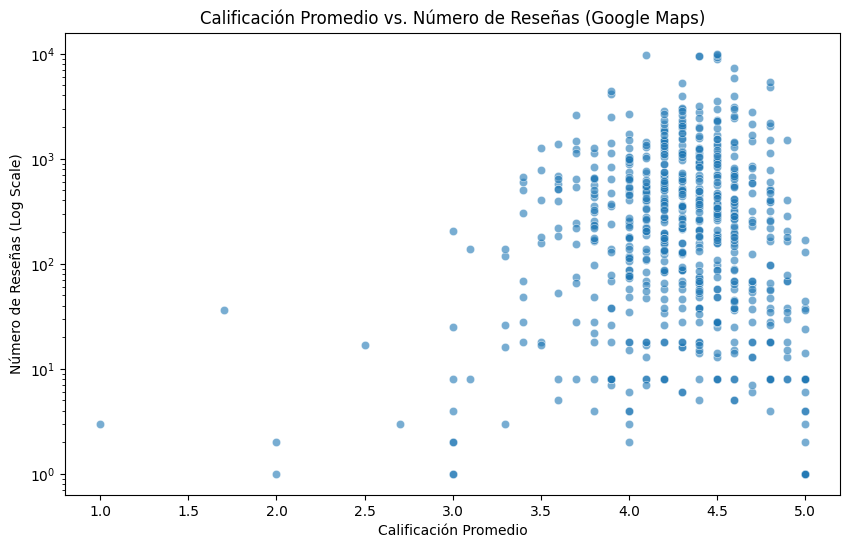

In [36]:
print("\n--- gmap_sites_df ---")
print("Primeras 5 filas:")
print(gmap_sites_df.head())
print("\nInformaci√≥n del DataFrame:")
print(gmap_sites_df.info())
print("\nEstad√≠sticas descriptivas:")
print(gmap_sites_df.describe())
print("\nConteo de valores nulos:")
print(gmap_sites_df.isnull().sum())

# Distribuci√≥n de la calificaci√≥n promedio (avg_rating)
plt.figure(figsize=(10, 6))
sns.histplot(gmap_sites_df['avg_rating'], bins=50, kde=True, color='purple')
plt.title('Distribuci√≥n de la Calificaci√≥n Promedio (Google Maps)')
plt.xlabel('Calificaci√≥n Promedio')
plt.ylabel('Conteo')
plt.show()

# Distribuci√≥n del n√∫mero de rese√±as (num_of_reviews)
plt.figure(figsize=(10, 6))
sns.histplot(gmap_sites_df['num_of_reviews'], bins=50, kde=True, color='brown')
plt.title('Distribuci√≥n del N√∫mero de Rese√±as (Google Maps)')
plt.xlabel('N√∫mero de Rese√±as')
plt.ylabel('Conteo')
plt.yscale('log') # Usar escala logar√≠tmica para ver la distribuci√≥n de valores bajos
plt.show()

# Relaci√≥n entre calificaci√≥n promedio y n√∫mero de rese√±as
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_rating', y='num_of_reviews', data=gmap_sites_df, alpha=0.6)
plt.title('Calificaci√≥n Promedio vs. N√∫mero de Rese√±as (Google Maps)')
plt.xlabel('Calificaci√≥n Promedio')
plt.ylabel('N√∫mero de Rese√±as (Log Scale)')
plt.yscale('log')
plt.show()

**An√°lisis de `gmap_sites_df`:**
* **`gmap_id`**: Identificador √∫nico del negocio en Google Maps.
* **`name`**: Nombre del negocio.
* **`address`, `state`, `zip_code`**: Informaci√≥n de ubicaci√≥n. Evaluar la completitud de estos datos.
* **`avg_rating`**: Variable num√©rica clave, likely skewed towards higher ratings.
* **`num_of_reviews`**: Otra variable num√©rica clave, que probablemente est√© muy sesgada (muchos negocios con pocas rese√±as, pocos con muchas). Podr√≠a requerir transformaci√≥n logar√≠tmica.
* **Valores Nulos**: Identificar qu√© columnas tienen valores nulos y planificar su manejo (imputaci√≥n, eliminaci√≥n).
* **Relaci√≥n Rating vs. Reviews**: Ver si los negocios con mejores calificaciones tienden a tener m√°s rese√±as y viceversa.

---

#### 2.2.2. `review_gmap_df` (Rese√±as de clientes)


--- review_gmap_df ---
Primeras 5 filas:
   review_id  text  rating                 user_id  \
0   10212006  None       4  1.0877908051438325e+20   
1   10205914  None       4  1.0608811953449578e+20   
2   10210843  None       4   1.146935889554338e+20   
3   10205875  None       4  1.1532668305493095e+20   
4   10212679  None       4  1.1333392094083128e+20   

                                 gmap_id                        date_time  \
0   0x89c134d5e9bba45f:0x2c113c8f0a877e6 2020-12-13 01:33:28.967000+00:00   
1  0x89c2516c60406dc7:0xff6c14336f717b2f 2018-09-17 20:49:07.993000+00:00   
2  0x89c253906d25596f:0xe7435039ef0abb10 2019-07-21 22:30:49.738000+00:00   
3  0x89c477a4860d2511:0xcd0191122babbbc6 2019-11-07 11:26:34.252000+00:00   
4  0x89c6cbfa6b96e289:0xd405a42fdf8e139f 2017-06-21 16:29:42.689000+00:00   

   sentiment_score sentiment_label  
0              0.0         neutral  
1              0.0         neutral  
2              0.0         neutral  
3              0.0    

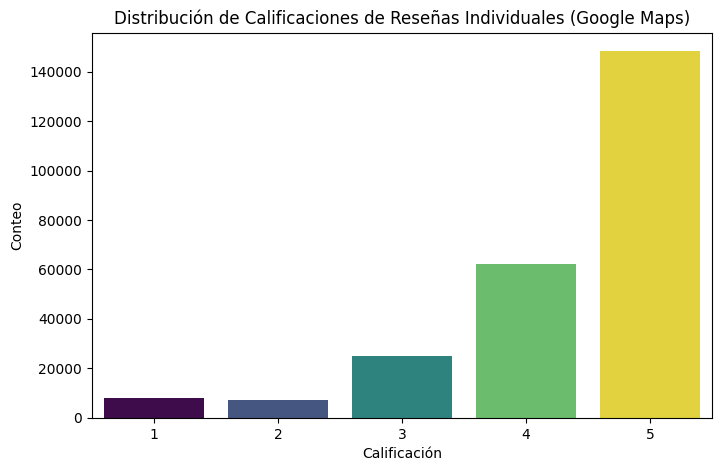

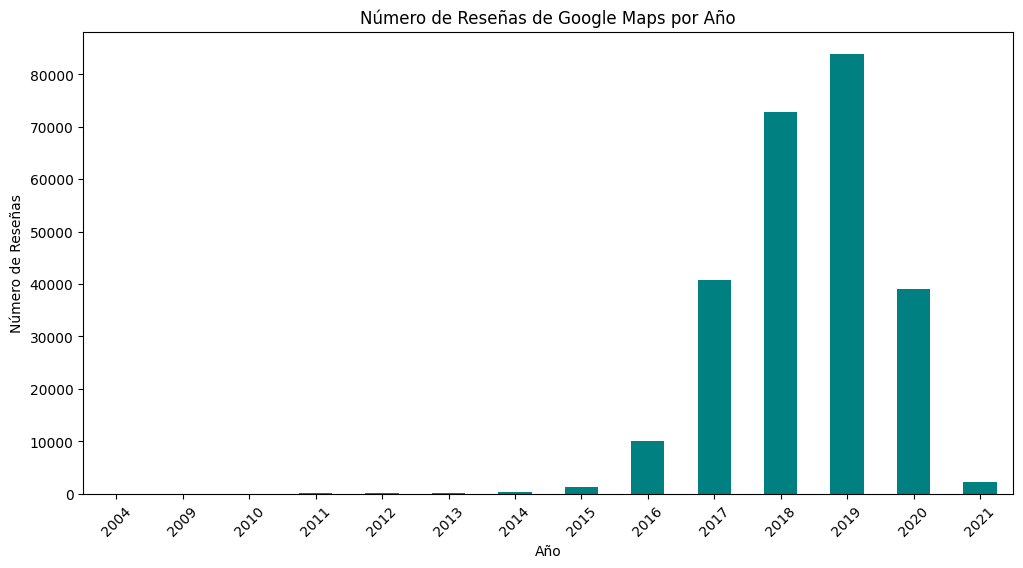

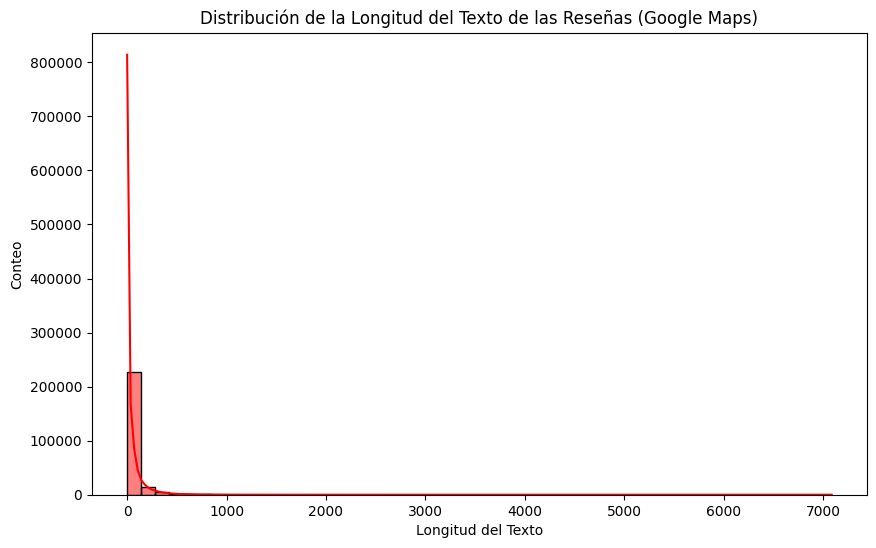

In [37]:
print("\n--- review_gmap_df ---")
print("Primeras 5 filas:")
print(review_gmap_df.head())
print("\nInformaci√≥n del DataFrame:")
print(review_gmap_df.info())
print("\nEstad√≠sticas descriptivas:")
print(review_gmap_df.describe())
print("\nConteo de valores nulos:")
print(review_gmap_df.isnull().sum())

# Distribuci√≥n de las calificaciones de las rese√±as individuales (rating)
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=review_gmap_df, palette='viridis', hue='rating', legend=False)
plt.title('Distribuci√≥n de Calificaciones de Rese√±as Individuales (Google Maps)')
plt.xlabel('Calificaci√≥n')
plt.ylabel('Conteo')
plt.show()

# Conversi√≥n de la columna 'date' a formato datetime
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date_time'], errors='coerce')

# An√°lisis temporal de las rese√±as (por a√±o)
plt.figure(figsize=(12, 6))
review_gmap_df['date'].dt.year.value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('N√∫mero de Rese√±as de Google Maps por A√±o')
plt.xlabel('A√±o')
plt.ylabel('N√∫mero de Rese√±as')
plt.xticks(rotation=45)
plt.show()

# Longitud del texto de las rese√±as
review_gmap_df['text_length'] = review_gmap_df['text'].fillna('').apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(review_gmap_df['text_length'], bins=50, kde=True, color='red')
plt.title('Distribuci√≥n de la Longitud del Texto de las Rese√±as (Google Maps)')
plt.xlabel('Longitud del Texto')
plt.ylabel('Conteo')
plt.show()

**An√°lisis de `review_gmap_df`:**
* **`review_id`, `gmap_id`, `user_id`**: Identificadores.
* **`rating`**: Calificaci√≥n individual de la rese√±a. Probablemente muy sesgada hacia 5 estrellas.
* **`text`**: El contenido de la rese√±a. √ötil para an√°lisis de texto (sentimiento, palabras clave).
* **`time`**: Columna de tiempo, que ahora convertimos a `date`.
* **Valores Nulos**: Prestar atenci√≥n a los `text` nulos.
* **Insights**: ¬øLa mayor√≠a de las rese√±as son positivas? ¬øHay tendencias en el tiempo? ¬øLas rese√±as m√°s largas tienen calificaciones diferentes?

#### 2.2.3. Tablas relacionales y de atributos de Google Maps

Estas tablas requieren **uniones (joins)** para ser √∫tiles.


--- gmap_sites_categories_df (Ejemplo de JOIN) ---
                                             address  \
0  Ricky's Toledo Towing Service | 24-Hour Roadsi...   
1            CVS, 1905 US-6, Carmel Hamlet, NY 10512   
2  The UPS Store, 398 W Army Trail Rd #124, Bloom...   
3  PostalAnnex+, 2658 Del Mar Heights Rd, Del Mar...   
4  PostalAnnex+, 2658 Del Mar Heights Rd, Del Mar...   

                                 gmap_id  \
0  0x80c2c663fbfa524b:0xf691797e079297cd   
1  0x89dd4d79f017cb9f:0xc48b42987559d179   
2  0x880fab7a207565db:0x5e45dcbb4481d639   
3  0x80dc08a10c8f272b:0xddc2c5e0f42649b7   
4  0x80dc08a10c8f272b:0xddc2c5e0f42649b7   

                                                name  avg_rating  \
0  Ricky's Toledo Towing Service | 24-Hour Roadsi...         1.9   
1                                                CVS         2.1   
2                                      The UPS Store         2.3   
3                                       PostalAnnex+         2.4   
4     

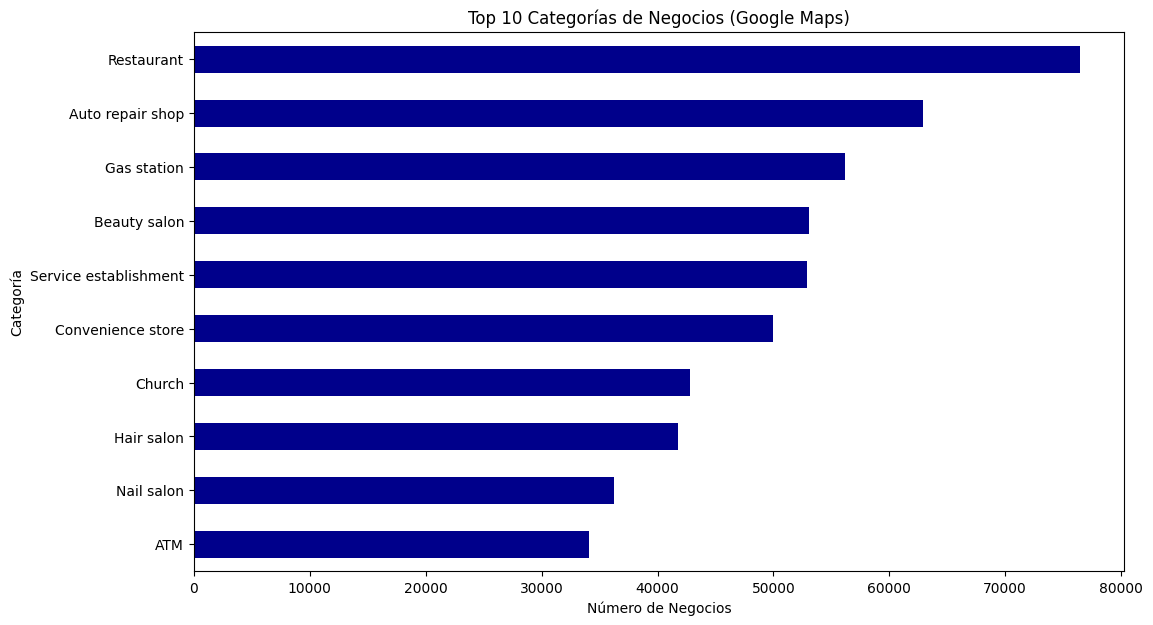

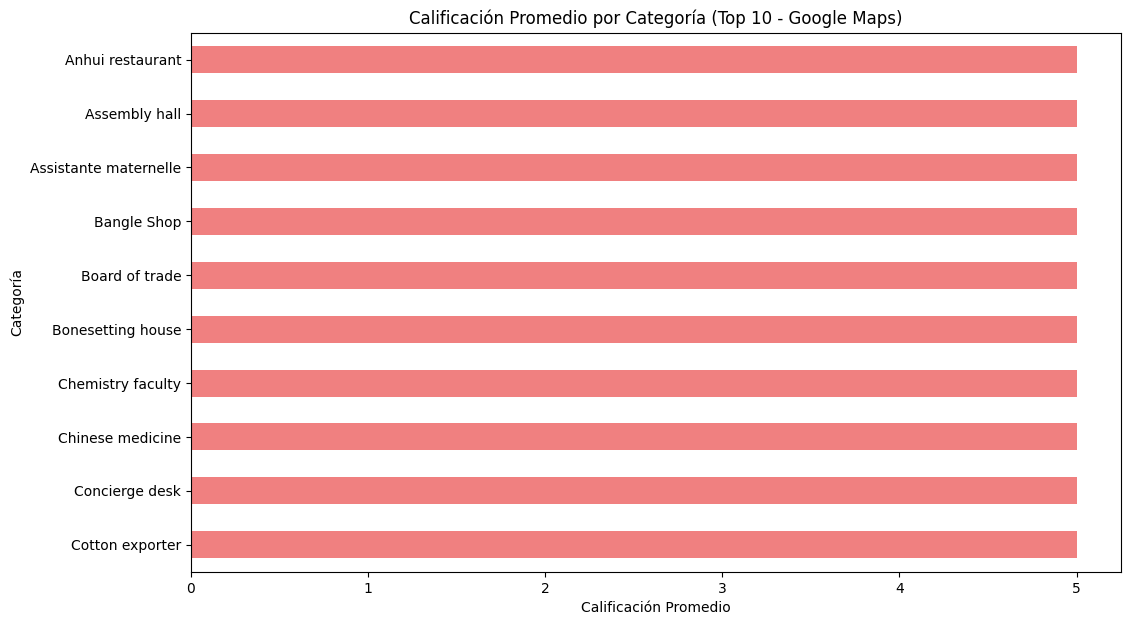

In [38]:
# Ejemplo de uni√≥n: gmap_sites con gmap_category_relacional y gmap_category
# Para ver las categor√≠as de los negocios
query_gmap_sites_categories = f"""
SELECT
    s.address,
    s.gmap_id,
    s.name,
    s.avg_rating,
    c.category_name
FROM
    `datawave-proyecto-final.gmaps_dataset.gmap_sites` AS s
JOIN
    `datawave-proyecto-final.gmaps_dataset.gmap_category_relacional` AS scr ON s.gmap_id = scr.gmap_id
JOIN
    `datawave-proyecto-final.gmaps_dataset.gmap_category` AS c ON scr.category_id = c.category_id
LIMIT {QUERY_LIMIT}
"""
gmap_sites_categories_df = client_us.query(query_gmap_sites_categories).to_dataframe()

print("\n--- gmap_sites_categories_df (Ejemplo de JOIN) ---")
print(gmap_sites_categories_df.head())
print(gmap_sites_categories_df.info())

# Top 10 categor√≠as de negocios
plt.figure(figsize=(12, 7))
gmap_sites_categories_df['category_name'].value_counts().head(10).plot(kind='barh', color='darkblue')
plt.title('Top 10 Categor√≠as de Negocios (Google Maps)')
plt.xlabel('N√∫mero de Negocios')
plt.ylabel('Categor√≠a')
plt.gca().invert_yaxis() # Para que la categor√≠a m√°s frecuente est√© arriba
plt.show()

# Calificaci√≥n promedio por categor√≠a (Top 10)
avg_rating_by_category = gmap_sites_categories_df.groupby('category_name')['avg_rating'].mean().nlargest(10)
plt.figure(figsize=(12, 7))
avg_rating_by_category.plot(kind='barh', color='lightcoral')
plt.title('Calificaci√≥n Promedio por Categor√≠a (Top 10 - Google Maps)')
plt.xlabel('Calificaci√≥n Promedio')
plt.ylabel('Categor√≠a')
plt.gca().invert_yaxis()
plt.show()

**An√°lisis de tablas relacionales de Google Maps:**
* **`gmap_attribute_relacional`, `gmap_attribute_types`, `gmap_attribute_values`**: Permiten entender los atributos espec√≠ficos de los negocios (e.g., "apto para ni√±os", "tiene Wi-Fi"). Se analizar√° la frecuencia de estos atributos y su relaci√≥n con las calificaciones/rese√±as.
* **`gmap_category_relacional`, `gmap_category`**: Esencial para categorizar los negocios y entender las diferencias de rendimiento entre tipos de establecimientos.
* **Tablas de Cocinas Espec√≠ficas (`Asian_Cuisine_Google`, etc.)**: Estas tablas NO EXISTEN como tablas independientes en este dataset, sino que ser√≠an el resultado de filtrar `gmap_sites` por categor√≠a. El an√°lisis de rendimiento por tipo de cocina se realizar√° a trav√©s de uniones y filtros.
* **`gmap_hours`**: Permite entender los patrones de horario de atenci√≥n y c√≥mo esto podr√≠a afectar la popularidad de un negocio.

---

### 2.3. `yelp_dataset`

Este conjunto de datos es similar al de Google Maps pero con su propia estructura y atributos √∫nicos.

#### 2.3.1. `yelp_business_df` (Informaci√≥n principal del negocio)

Inspeccionaremos las columnas disponibles para los negocios de Yelp.


--- yelp_business_df ---
Primeras 5 filas:
              business_id            name           address      city state  \
0  rkqsFfbdeuXevR4Z3VgFuA      McDonald's  1663 Old York Rd  Abington    NJ   
1  Thavh5iKWC0KYhYp5dEWeQ         TJ Maxx  1495 Old York Rd  Abington    NJ   
2  71142Ice897c19VUQmVFLg  Abington Nails  1423 Old York Rd  Abington    NJ   
3  xU04OJtdN9XFmicHziwU9A    Blinds To Go  1936 Old York Rd  Abington    NJ   
4  -lM78iJEh0GH5MkgE-_u5g    Jimmy John's  1140 Old York Rd  Abington    NJ   

  postal_code   latitude  longitude  stars  review_count  __index_level_0__  
0       19001  40.131196 -75.115782    1.5            84             139609  
1       19001  40.125300 -75.115679    2.5            20              45445  
2       19001  40.122939 -75.116085    2.5            47             120410  
3       19001  40.138626 -75.113284    2.5            15             146367  
4       19001  40.115986 -75.121391    3.0            17              51919  

Informaci√≥n

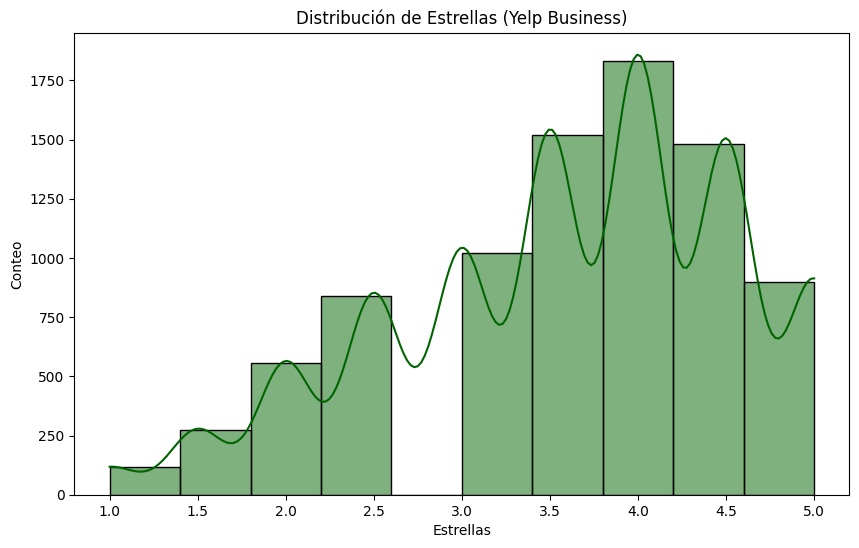

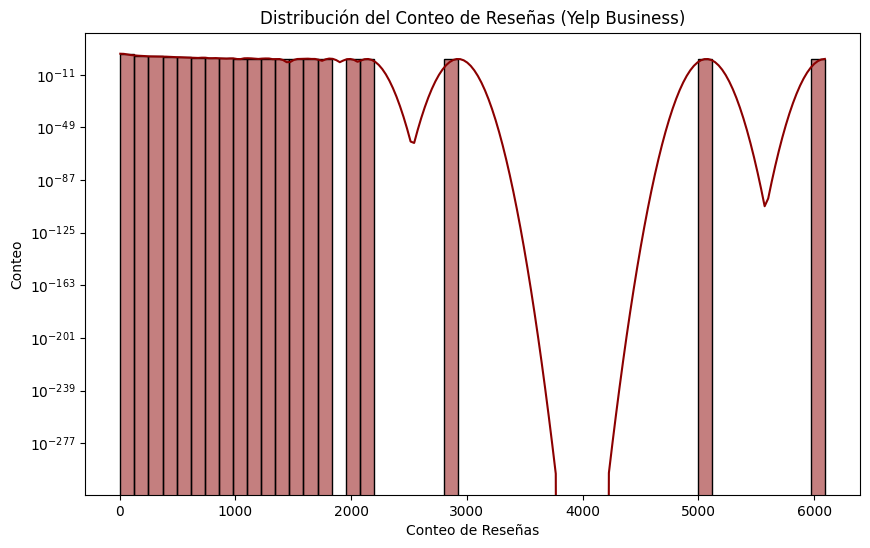

In [39]:
print("\n--- yelp_business_df ---")
print("Primeras 5 filas:")
print(yelp_business_df.head())
print("\nInformaci√≥n del DataFrame:")
print(yelp_business_df.info())
print("\nEstad√≠sticas descriptivas:")
print(yelp_business_df.describe())
print("\nConteo de valores nulos:")
print(yelp_business_df.isnull().sum())

# Distribuci√≥n de las estrellas (calificaci√≥n) de Yelp
plt.figure(figsize=(10, 6))
sns.histplot(yelp_business_df['stars'], bins=10, kde=True, color='darkgreen')
plt.title('Distribuci√≥n de Estrellas (Yelp Business)')
plt.xlabel('Estrellas')
plt.ylabel('Conteo')
plt.show()

# Distribuci√≥n del conteo de rese√±as (review_count)
plt.figure(figsize=(10, 6))
sns.histplot(yelp_business_df['review_count'], bins=50, kde=True, color='darkred')
plt.title('Distribuci√≥n del Conteo de Rese√±as (Yelp Business)')
plt.xlabel('Conteo de Rese√±as')
plt.ylabel('Conteo')
plt.yscale('log') # Usar escala logar√≠tmica
plt.show()

**An√°lisis de `yelp_business_df`:**
* **`business_id`**: Identificador √∫nico del negocio en Yelp.
* **`stars`**: Calificaci√≥n promedio del negocio en Yelp (similar a `avg_rating` en Google Maps).
* **`review_count`**: N√∫mero total de rese√±as.
* **`address`, `city`, `state`, `postal_code`**: Informaci√≥n de ubicaci√≥n.
* **Valores Nulos**: Identificar y manejar.
* **Consideraci√≥n de '√©xito'**: Como la columna `is_open` no est√° presente en el esquema de la tabla `yelp_business` en BigQuery, el "√©xito" del negocio deber√° definirse a partir de otras m√©tricas como `stars` y `review_count`.

#### 2.3.2. `review_yelp_df` (Rese√±as de clientes)


--- review_yelp_df ---
Primeras 5 filas:
                review_id                 user_id             business_id  \
0  2uWq21Bq3j9RMDna0W_QWA  y-FlbbTzdRRdUwJpAiJfJg  q-6zZAqF4ARfw05oZUXnLQ   
1  BsFFwGB_4rkH1luaMjtAyQ  KrZP9pKVlV_kecf3XPDhAw  7w1kfRXe_OYTvWU2NHE8QQ   
2  gXFQCwCZE_kX8VmgU36gXg  hSbCSR7F8HAwfoZcm0jpww  YWfOxkw6ZqMOsVm3hsv2ig   
3  ClRAwes00js2yf9Tl8sM6A  NQ3ODjQuivlZT4P_GLhe9A  UQZ4p6xb_7gY7UXHmBzceg   
4  dulp5MXN_OARNuYNhy7oPA  miu-fYbZDHC1Ue5fTlXPSA  0wHUCfnfSzTdtwlTTAPoKA   

                       date  stars  \
0 2012-05-17 22:09:41+00:00    1.0   
1 2015-09-16 06:15:13+00:00    1.0   
2 2017-04-10 14:47:37+00:00    1.0   
3 2016-04-23 23:08:54+00:00    1.0   
4 2016-07-15 20:16:05+00:00    1.0   

                                                text  useful  funny  cool  
0  If I could give them 0 stars I would. I just h...       5      1     1  
1  Stopped by for lunch today around 12:30pm. The...       0      1     0  
2  I would not recommend this place. T

<ipython-input-40-390de61c0f40>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=review_yelp_df, palette='cividis')


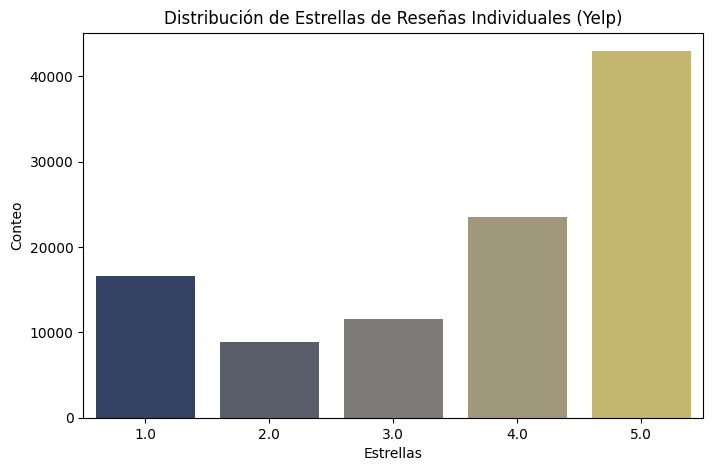

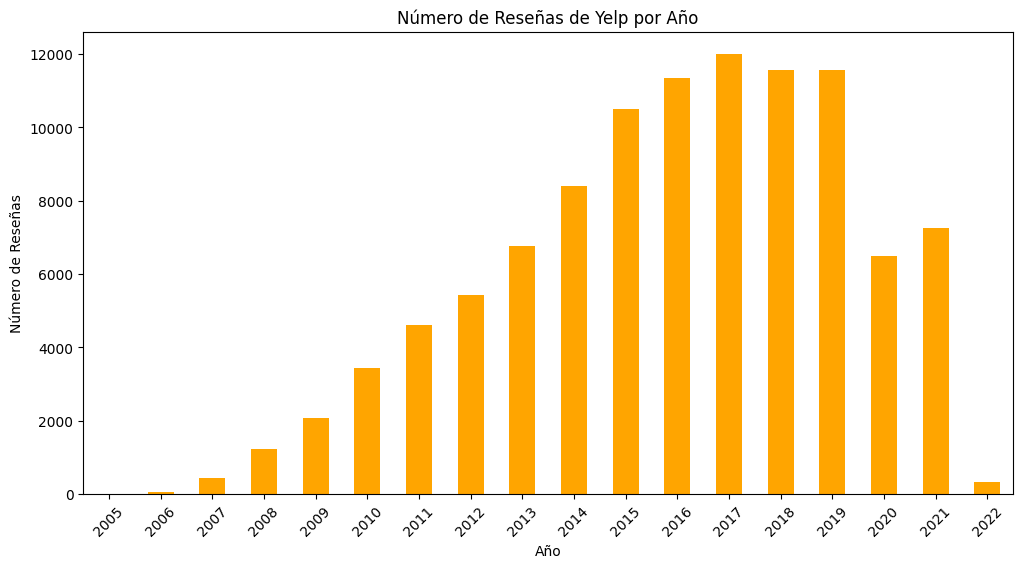

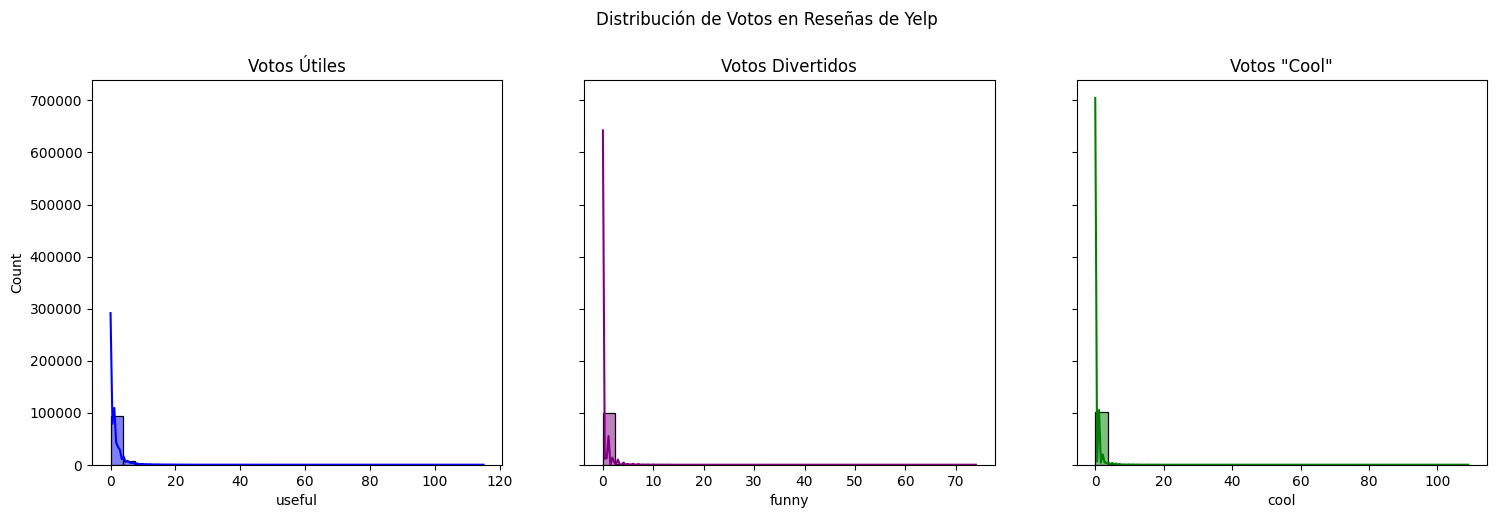

In [40]:
print("\n--- review_yelp_df ---")
print("Primeras 5 filas:")
print(review_yelp_df.head())
print("\nInformaci√≥n del DataFrame:")
print(review_yelp_df.info())
print("\nEstad√≠sticas descriptivas:")
print(review_yelp_df.describe())
print("\nConteo de valores nulos:")
print(review_yelp_df.isnull().sum())

# Distribuci√≥n de las estrellas de las rese√±as individuales
plt.figure(figsize=(8, 5))
sns.countplot(x='stars', data=review_yelp_df, palette='cividis')
plt.title('Distribuci√≥n de Estrellas de Rese√±as Individuales (Yelp)')
plt.xlabel('Estrellas')
plt.ylabel('Conteo')
plt.show()

# Conversi√≥n de la columna 'date' a formato datetime
review_yelp_df['date'] = pd.to_datetime(review_yelp_df['date'], errors='coerce')
# An√°lisis temporal de las rese√±as (por a√±o)
plt.figure(figsize=(12, 6))
review_yelp_df['date'].dt.year.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('N√∫mero de Rese√±as de Yelp por A√±o')
plt.xlabel('A√±o')
plt.ylabel('N√∫mero de Rese√±as')
plt.xticks(rotation=45)
plt.show()

# Distribuci√≥n de votos 'useful', 'funny', 'cool'
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
sns.histplot(review_yelp_df['useful'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Votos √ötiles')
sns.histplot(review_yelp_df['funny'], bins=30, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Votos Divertidos')
sns.histplot(review_yelp_df['cool'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Votos "Cool"')
plt.suptitle('Distribuci√≥n de Votos en Rese√±as de Yelp', y=1.02)
plt.show()

**An√°lisis de `review_yelp_df`:**
* **`review_id`, `user_id`, `business_id`**: Identificadores.
* **`stars`**: Calificaci√≥n individual de la rese√±a.
* **`text`**: Contenido de la rese√±a.
* **`date`**: Fecha de la rese√±a.
* **`useful`, `funny`, `cool`**: Votos de los usuarios sobre la utilidad, diversi√≥n o "coolness" de una rese√±a. Son caracter√≠sticas √∫nicas de Yelp y muy valiosas.
* **Valores Nulos**: Analizar `text` nulos.
* **Insights**: ¬øC√≥mo se distribuyen los votos? ¬øLas rese√±as con muchos votos tienen calificaciones m√°s altas o m√°s bajas?

#### 2.3.3. Tablas relacionales y de atributos de Yelp

Al igual que con Google Maps, estas tablas se vuelven poderosas cuando se unen.


--- yelp_business_categories_df (Ejemplo de JOIN) ---
                              name  stars category_name
0                          Lincare    1.0       Doctors
1            Exodus Women's Center    1.0       Doctors
2  Advanced Neurodiagnostic Center    1.0       Doctors
3              Doctor Diet Centers    1.0       Doctors
4                    Derm-Care, PC    1.0       Doctors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668592 entries, 0 to 668591
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           668592 non-null  object 
 1   stars          668592 non-null  float64
 2   category_name  668592 non-null  object 
dtypes: float64(1), object(2)
memory usage: 15.3+ MB
None


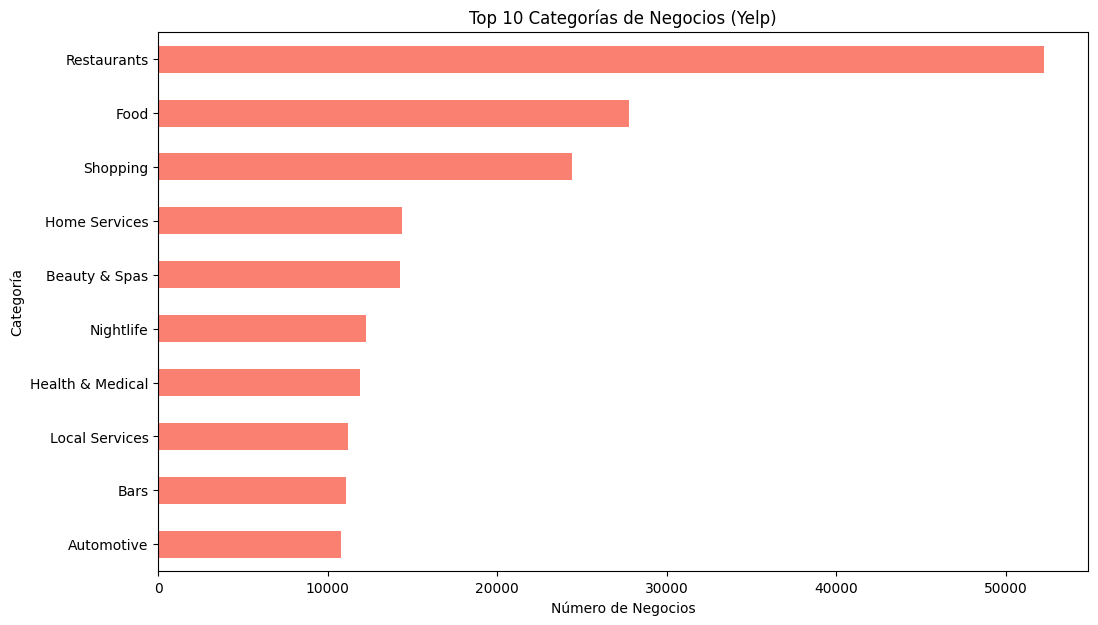

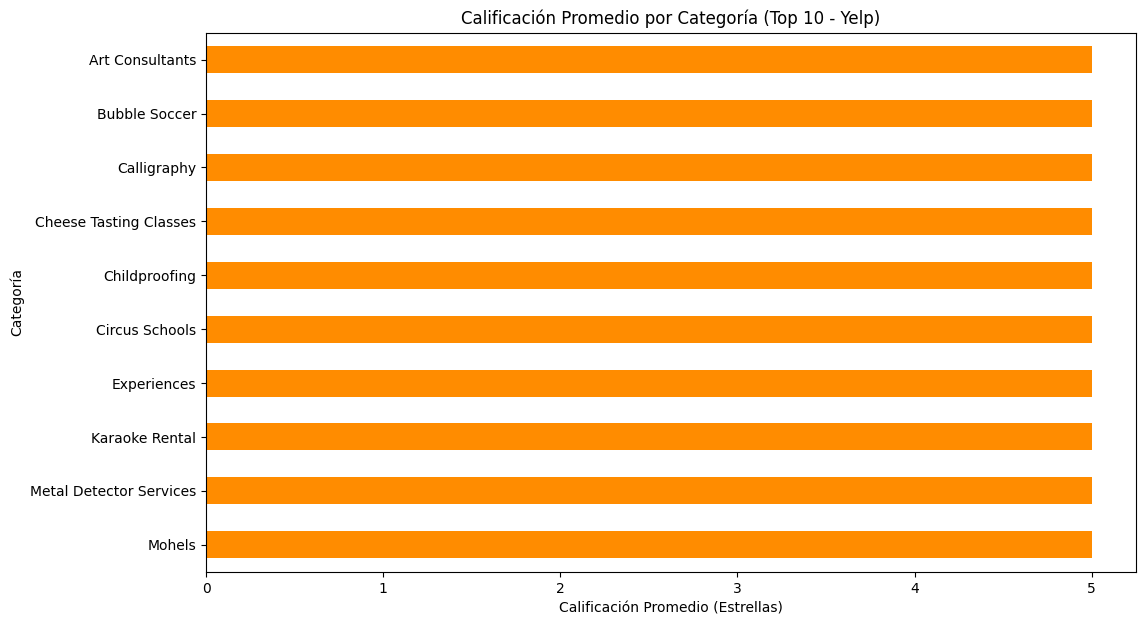

In [41]:
# Ejemplo de uni√≥n: yelp_business con yelp_category_rel y yelp_category
# Para ver las categor√≠as de los negocios
query_yelp_business_categories = f"""
SELECT
    yb.name,
    yb.stars,
    yc.category_name
FROM
    `datawave-proyecto-final.yelpdataset.yelp_business` AS yb
JOIN
    `datawave-proyecto-final.yelpdataset.yelp_category_rel` AS ycr ON yb.business_id = ycr.business_id
JOIN
    `datawave-proyecto-final.yelpdataset.yelp_category` AS yc ON ycr.category_id = yc.category_id
LIMIT {QUERY_LIMIT}
"""
yelp_business_categories_df = client_us.query(query_yelp_business_categories).to_dataframe()

print("\n--- yelp_business_categories_df (Ejemplo de JOIN) ---")
print(yelp_business_categories_df.head())
print(yelp_business_categories_df.info())

# Top 10 categor√≠as de negocios
plt.figure(figsize=(12, 7))
yelp_business_categories_df['category_name'].value_counts().head(10).plot(kind='barh', color='salmon')
plt.title('Top 10 Categor√≠as de Negocios (Yelp)')
plt.xlabel('N√∫mero de Negocios')
plt.ylabel('Categor√≠a')
plt.gca().invert_yaxis()
plt.show()

# Calificaci√≥n promedio por categor√≠a (Top 10)
avg_stars_by_category = yelp_business_categories_df.groupby('category_name')['stars'].mean().nlargest(10)
plt.figure(figsize=(12, 7))
avg_stars_by_category.plot(kind='barh', color='darkorange')
plt.title('Calificaci√≥n Promedio por Categor√≠a (Top 10 - Yelp)')
plt.xlabel('Calificaci√≥n Promedio (Estrellas)')
plt.ylabel('Categor√≠a')
plt.gca().invert_yaxis()
plt.show()

---

## 3. Ingenier√≠a de Features (Basada en el EDA)

Una vez que hayamos completado el EDA, podremos identificar oportunidades para crear nuevas features que mejoren el poder predictivo de nuestro modelo. Aqu√≠ hay algunas ideas, que se confirmar√°n o ajustar√°n con base en lo que revele el EDA detallado:

* **Desde `census_df`**:
    * Podr√≠amos agregar **`median_household_income`**, **`median_home_value`** y **`total_population`** a los datos de negocios de Google Maps o Yelp si podemos mapear los negocios a los condados.
* **Desde `gmap_sites_df` y `yelp_business_df`**:
    * **Ratio de Rese√±as por Calificaci√≥n M√°xima**: `num_of_reviews` / `max_reviews_in_category` (normalizaci√≥n).
    * **Antig√ºedad del Negocio**: Si hay una fecha de apertura disponible o se puede inferir del primer registro de rese√±a.
* **Desde `review_gmap_df` y `review_yelp_df`**:
    * **Sentimiento de Rese√±as**: Derivar una puntuaci√≥n de sentimiento (requiere procesamiento de lenguaje natural) del **`text`**.
    * **Votos por Rese√±a (Yelp)**: Ratios como `useful` / `text_length` o `useful` / `total_votes`.
    * **Variabilidad de Calificaciones**: Desviaci√≥n est√°ndar de las calificaciones de las rese√±as para un negocio.
    * **Frecuencia de Rese√±as**: N√∫mero de rese√±as por mes/a√±o para un negocio.
* **Desde atributos y categor√≠as (Google Maps y Yelp)**:
    * **Variables Dummies/One-Hot Encoding**: Convertir atributos categ√≥ricos importantes (e.g., 'Tiene Wi-Fi', 'Acepta Reservas') en columnas binarias (0 o 1).
    * **Conteo de Atributos**: N√∫mero total de atributos que tiene un negocio.
    * **Calificaci√≥n Promedio por Categor√≠a**: Unir esta m√©trica a cada negocio.

---

## 4. Selecci√≥n de Features

La **selecci√≥n de features** es crucial para construir un modelo eficiente y robusto. Basaremos nuestra selecci√≥n en el EDA, priorizando las features que muestren la mayor relaci√≥n con nuestra variable objetivo.

**Criterios de Selecci√≥n:**

1.  **Relevancia con la Variable Objetivo**: Features que muestren una fuerte correlaci√≥n (para variables num√©ricas) o una clara diferencia de distribuci√≥n (para variables categ√≥ricas) con la variable que queremos predecir (e.g., calificaci√≥n alta, negocio exitoso/abierto).
2.  **Menos Valores Nulos**: Preferiremos features con menos valores nulos, o aquellos que podamos imputar de manera confiable.
3.  **Baja Redundancia/Multicolinealidad**: Evitaremos incluir features altamente correlacionadas entre s√≠ (e.g., si `median_household_income` y `median_home_value` son casi id√©nticas, podr√≠amos elegir una).
4.  **Variabilidad**: Features con poca variabilidad (e.g., una columna que es casi siempre el mismo valor) aportan poco al modelo.
5.  **Interpretaci√≥n y Conocimiento del Dominio**: Features que tienen un sentido l√≥gico en el contexto del negocio o la demograf√≠a.

**Features Candidatas (Ejemplos, basadas en el EDA previo):**

* **Num√©ricas**:
    * `avg_rating` (GMaps) / `stars` (Yelp)
    * `num_of_reviews` (GMaps) / `review_count` (Yelp)
    * `median_household_income` (Censo)
    * `median_home_value` (Censo)
    * `total_population` (Censo)
    * `text_length` (rese√±as)
    * `useful`, `funny`, `cool` (Yelp reviews)
    * Features de Ingenier√≠a: `review_velocity`, `rating_deviation_from_category_mean`.
* **Categ√≥ricas (despu√©s de One-Hot Encoding)**:
    * `category_name` (las top N categor√≠as m√°s relevantes)
    * `attribute_name` (los atributos m√°s comunes e impactantes, e.g., 'Has Wi-Fi', 'OutdoorSeating', 'RestaurantsReservations').
* **Identificadores**: `gmap_id`, `business_id` (√∫tiles para uniones pero no para el modelo directamente).
* **Variables de Texto**: El texto crudo de las rese√±as (`text`) no se usar√≠a directamente, sino features derivadas de √©l (sentimiento, palabras clave, etc.).

---

## 5. Fundamentaci√≥n de la Elecci√≥n del Modelo y Criterios de Desarrollo

### 5.1. Definici√≥n del Problema y Variable Objetivo

Basado en el EDA, es probable que tengamos dos tipos de problemas principales en mente:

1.  **Clasificaci√≥n**: Predecir si un negocio es **"exitoso"** (e.g., top 25% por calificaci√≥n y rese√±as) o no.
2.  **Regresi√≥n**: Predecir la **calificaci√≥n promedio** de un negocio (`avg_rating` / `stars`).

Vamos a asumir un problema de **Clasificaci√≥n**: **Predecir si un negocio es exitoso**. El "√©xito" se podr√≠a definir como:
* Calificaci√≥n promedio $\geq$ 4.0 y `num_of_reviews` $\geq$ 50 (esto se ajustar√≠a despu√©s del EDA).

### 5.2. Justificaci√≥n de la Elecci√≥n del Modelo

Dadas las caracter√≠sticas de nuestros datos (mezcla de features num√©ricas y categ√≥ricas, posibles relaciones no lineales, volumen considerable de datos):

* **Modelos Basados en √Årboles (Gradient Boosting, Random Forest)**:
    * **Ventajas**: Son muy robustos, manejan bien la interacci√≥n entre features, no requieren escalado de features, son excelentes para datos con relaciones no lineales, y funcionan bien con datos tabulares. Son menos sensibles a outliers que los modelos lineales. **XGBoost** o **LightGBM** son opciones particularmente buenas por su eficiencia y rendimiento.
    * **Justificaci√≥n basada en EDA**: El EDA probablemente revelar√° que la relaci√≥n entre, por ejemplo, el `ingreso_medio_hogar` y la `calificaci√≥n_promedio` de un negocio no es puramente lineal, sino que hay puntos de quiebre o interacciones complejas con otras features como las categor√≠as o atributos. Los modelos basados en √°rboles son ideales para capturar estas complejidades. Adem√°s, la naturaleza de las categor√≠as y atributos (muchas features categ√≥ricas) se maneja bien con estos modelos tras una codificaci√≥n adecuada (e.g., One-Hot Encoding).

* **Alternativas (si el EDA mostrara otras cosas):**
    * **Regresi√≥n Log√≠stica/Lineal**: Si el EDA mostrara relaciones predominantemente lineales y la interpretabilidad fuera la m√°xima prioridad.
    * **Redes Neuronales**: Si el volumen de datos fuera masivo y las relaciones extremadamente complejas, especialmente si el procesamiento avanzado de texto (NLP) de las rese√±as fuera un componente central del modelo.

**Nuestra elecci√≥n preferida ser√≠a un algoritmo de Gradient Boosting (como XGBoost o LightGBM).**

### 5.3. Criterios para el Desarrollo del Modelo

Basados en el EDA y la selecci√≥n de features, los criterios para el desarrollo del modelo incluir√°n:

1.  **Preprocesamiento de Datos**:
    * **Manejo de Valores Nulos**: Imputaci√≥n de columnas num√©ricas con la media/mediana o eliminaci√≥n de filas/columnas seg√∫n el porcentaje de nulos.
    * **Codificaci√≥n de Variables Categ√≥ricas**: Uso de One-Hot Encoding para las features categ√≥ricas nominales (e.g., `category_name`, `attribute_name`).
    * **Escalado de Features Num√©ricas**: Aunque los modelos basados en √°rboles no lo exigen estrictamente, puede ser √∫til para algunos pasos de ingenier√≠a de features o si se prueban otros modelos.
    * **Transformaci√≥n de Features Sesgadas**: Aplicar transformaciones logar√≠tmicas a features como `num_of_reviews` o `total_population` si su distribuci√≥n es muy asim√©trica.

2.  **Preparaci√≥n del Conjunto de Datos**:
    * **Integraci√≥n de Datos**: Si es posible, unificar las features relevantes de los datasets de Census, Google Maps y Yelp en un √∫nico DataFrame maestro utilizando `county_fips` o coordenadas geogr√°ficas para el mapeo.
    * **Divisi√≥n de Datos**: Dividir el conjunto de datos en conjuntos de **entrenamiento**, **validaci√≥n** y **prueba** (e.g., 70-15-15% o 80-20%). La divisi√≥n se realizar√° de manera estratificada si la variable objetivo est√° desbalanceada.

3.  **Evaluaci√≥n del Modelo**:
    * **M√©tricas para Clasificaci√≥n**:
        * **Recall y Precision**: Para evaluar la capacidad del modelo para identificar correctamente los negocios "exitosos" o "no exitosos", especialmente si hay un desbalance de clases.
        * **F1-Score**: La media arm√≥nica de precisi√≥n y recall, √∫til para problemas con clases desbalanceadas.
        * **Curva ROC-AUC**: Para evaluar el rendimiento general del clasificador en diferentes umbrales.
        * **Accuracy**: Se considerar√°, pero no ser√° la m√©trica principal si hay un desbalance de clases significativo.
    * **Validaci√≥n Cruzada (Cross-Validation)**: Utilizaremos K-Fold Cross-Validation para asegurar que la evaluaci√≥n del rendimiento del modelo sea robusta y no dependa de una √∫nica divisi√≥n de datos.

4.  **Optimizaci√≥n del Modelo**:
    * **Ajuste de Hiperpar√°metros**: Utilizaremos t√©cnicas como `GridSearchCV` o `RandomizedSearchCV` para encontrar la mejor combinaci√≥n de hiperpar√°metros para el modelo elegido.
    * **Manejo del Desbalance de Clases**: Si la clase "√©xito" est√° subrepresentada, consideraremos t√©cnicas como `SMOTE` (Synthetic Minority Over-sampling Technique) para el sobremuestreo de la clase minoritaria, o el ajuste de los pesos de clase dentro del algoritmo del modelo.

Con este enfoque estructurado, podr√°s realizar un an√°lisis de datos completo y construir un modelo robusto y bien justificado.

## Gr√°fico 1: Condados con mayor densidad poblacional
Este gr√°fico muestra los condados de mayor densidad de poblaci√≥n, calculada como poblaci√≥n total dividida por √°rea en millas cuadradas.

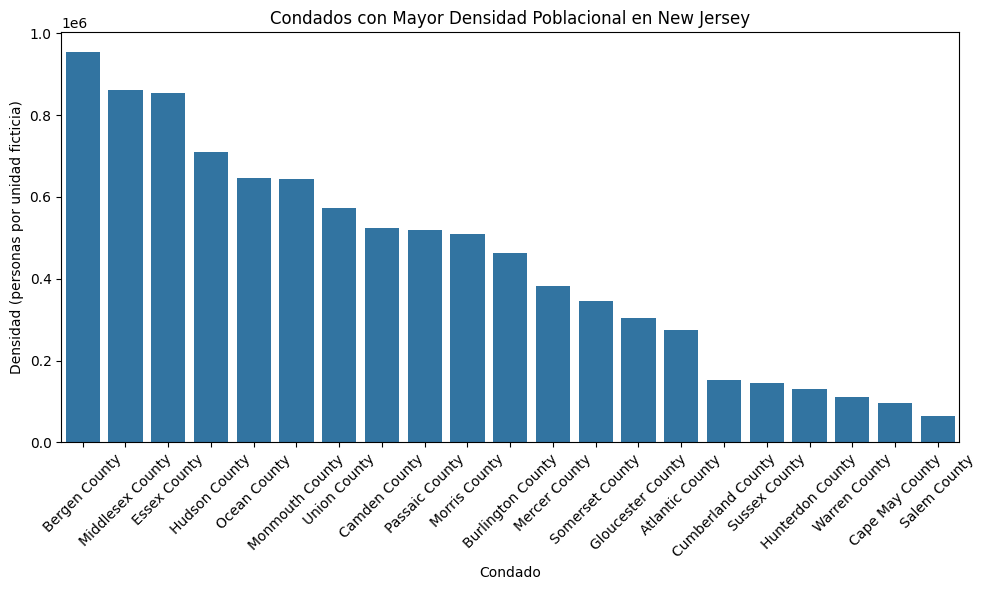

In [42]:
# Calcular densidad antes de usarla
census_df['population_density'] = census_df['total_population'] / 1  # o por √°rea si la tuvieras

# Limpiar el nombre del condado
census_df['clean_county_name'] = census_df['county_name'].str.replace(r',?\s*New Jersey$', '', regex=True)

# Ordenar por densidad
density_counties = census_df.sort_values(by="population_density", ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=density_counties, x='clean_county_name', y='population_density')
plt.title('Condados con Mayor Densidad Poblacional en New Jersey')
plt.ylabel('Densidad (personas por unidad ficticia)')
plt.xlabel('Condado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Gr√°fico 2: Cantidad de rese√±as de categor√≠a restaurante por estado (Top 10)
Muestra cu√°ntas rese√±as han recibido los restaurantes en los distintos estados.

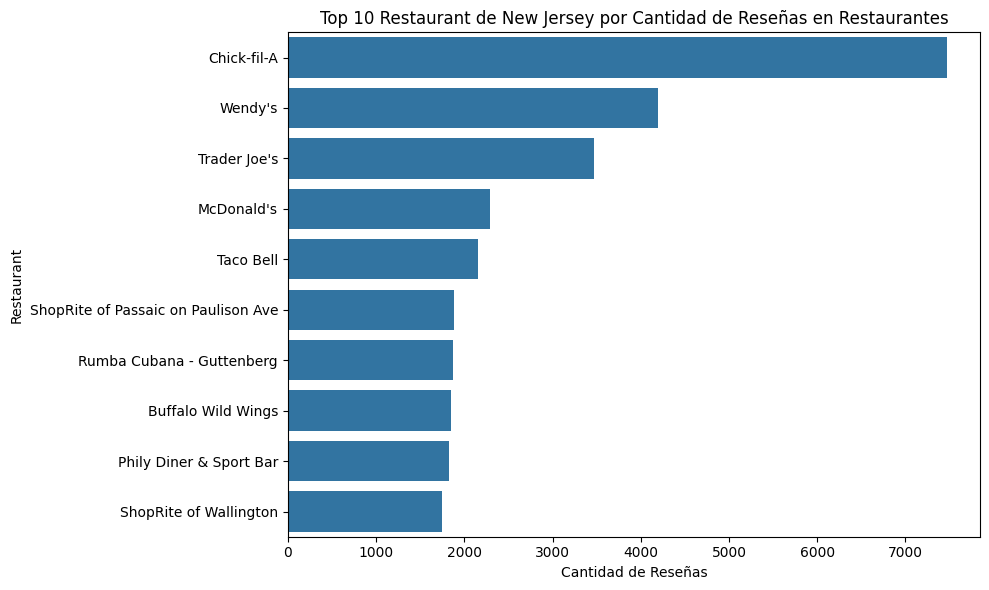

In [43]:
# 1. Definir palabras clave relacionadas a comida
keywords = ['restaurant', 'food', 'bar', 'cafe', 'eatery', 'diner', 'bistro']

# 2. Filtrar gmap_ids donde la categor√≠a est√© relacionada
restaurant_ids = gmap_sites_categories_df[
    gmap_sites_categories_df['category_name'].str.lower().str.contains('|'.join(keywords), na=False)
]['gmap_id'].unique()

# 3. Extraer ciudad desde la direcci√≥n (antes de la primera coma)
gmap_sites_df['city'] = gmap_sites_df['address'].str.extract(r'^([^,]+)', expand=False)

# 4. Crear un mapa de gmap_id a ciudad
city_map = gmap_sites_df.set_index('gmap_id')['city'].to_dict()
# 5. Filtrar reviews y asignar ciudad a cada una
restaurant_reviews = review_gmap_df[review_gmap_df['gmap_id'].isin(restaurant_ids)].copy()
restaurant_reviews['city'] = restaurant_reviews['gmap_id'].map(city_map)

# 6. Agrupar y graficar por ciudad
reviews_by_city = restaurant_reviews.groupby('city').size().sort_values(ascending=False).head(10)

# 7. Graficar
plt.figure(figsize=(10,6))
sns.barplot(x=reviews_by_city.values, y=reviews_by_city.index)
plt.title('Top 10 Restaurant de New Jersey por Cantidad de Rese√±as en Restaurantes')
plt.xlabel('Cantidad de Rese√±as')
plt.ylabel('Restaurant')
plt.tight_layout()
plt.show()

## Gr√°fico 3: Distribuci√≥n del Ingreso Medio por Hogar
Esta distribuci√≥n permite entender la riqueza relativa de los condados.

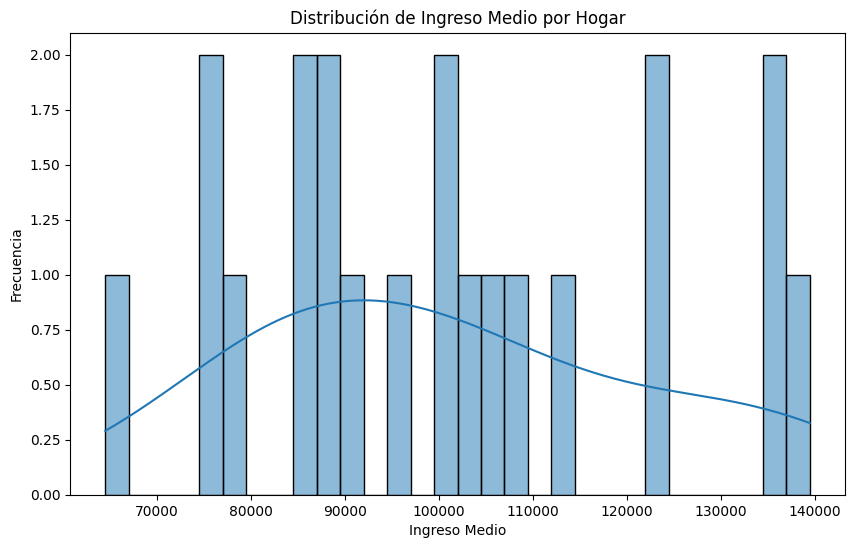

In [44]:
# Usamos census_df con columna 'median_household_income'
plt.figure(figsize=(10,6))
sns.histplot(census_df['median_household_income'], bins=30, kde=True)
plt.title('Distribuci√≥n de Ingreso Medio por Hogar')
plt.xlabel('Ingreso Medio')
plt.ylabel('Frecuencia')
plt.show()

## Gr√°fico 4: Densidad de Rese√±as
Este gr√°fico muestra la relaci√≥n entre la cantidad de rese√±as y la cantidad de restaurantes por estado.

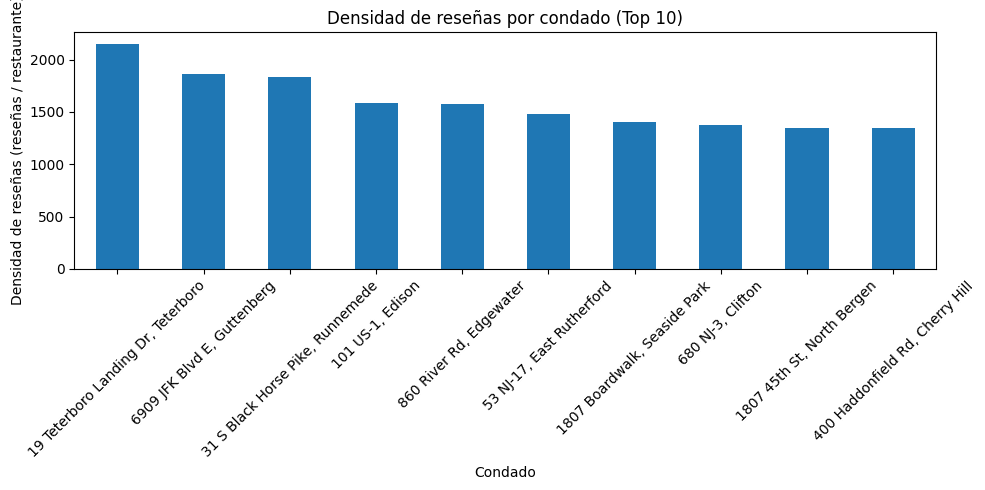

In [45]:
# Extraer el condado de la direcci√≥n
gmap_sites_df['county'] = gmap_sites_df['address'].str.extract(r',\s*(.*?)\s*,\s*NJ\s+\d{5},\s*United States')

# Repetir proceso de filtrado y merge, pero usando 'county'
restaurant_ids = gmap_sites_categories_df[
    gmap_sites_categories_df['category_name'].str.lower().str.contains('restaurant')
]['gmap_id'].unique()

restaurant_data = gmap_sites_df[gmap_sites_df['gmap_id'].isin(restaurant_ids)].copy()
restaurant_reviews = review_gmap_df[review_gmap_df['gmap_id'].isin(restaurant_ids)].copy()

# Agregar columna 'county' a los reviews usando merge
restaurant_reviews = restaurant_reviews.merge(
    gmap_sites_df[['gmap_id', 'county']],
    on='gmap_id',
    how='left'
)

# Asegurar que ambas tengan la columna 'county' sin nulos
restaurant_reviews = restaurant_reviews.dropna(subset=['county'])
restaurant_data = restaurant_data.dropna(subset=['county'])

# Agrupar por county
reviews_per_county = restaurant_reviews.groupby('county').size()
restaurants_per_county = restaurant_data.groupby('county').size()

# Calcular densidad de rese√±as por restaurante
density_reviews = (reviews_per_county / restaurants_per_county).dropna().sort_values(ascending=False)

import matplotlib.pyplot as plt

if not density_reviews.empty:
    density_reviews.head(10).plot(kind='bar', figsize=(10, 5), title='Densidad de rese√±as por condado (Top 10)')
    plt.ylabel('Densidad de rese√±as (rese√±as / restaurante)')
    plt.xlabel('Condado')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos suficientes para calcular la densidad de rese√±as.")


## Gr√°fico 5: Evoluci√≥n de la Cantidad de Rese√±as en el Tiempo
Permite analizar tendencias en el uso de la plataforma a lo largo del tiempo.

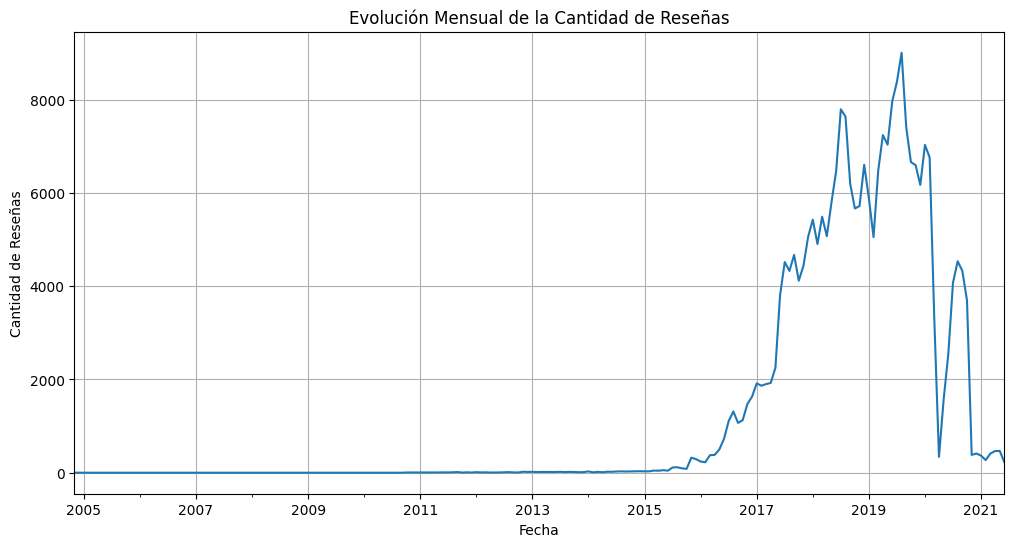

In [46]:
# Usamos review_gmap_df con columna 'date'
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date'])
monthly_reviews = review_gmap_df.set_index('date').resample('ME').size()

plt.figure(figsize=(12,6))
monthly_reviews.plot()
plt.title('Evoluci√≥n Mensual de la Cantidad de Rese√±as')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Rese√±as')
plt.grid(True)
plt.show()

## Gr√°fico 6: Evoluci√≥n de Rese√±as Positivas, Neutrales y Negativas
Muestra c√≥mo ha cambiado la percepci√≥n de los usuarios a lo largo del tiempo.

<Figure size 1200x600 with 0 Axes>

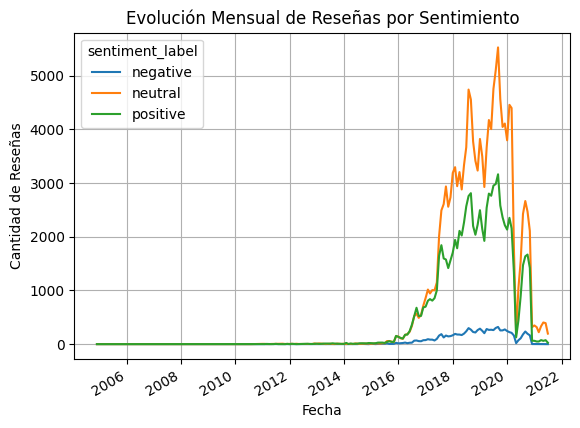

In [47]:
# Asumiendo columna 'sentiment_label' en review_gmap_df ['positive', 'neutral', 'negative']
review_gmap_df['date'] = pd.to_datetime(review_gmap_df['date'])
sentiment_monthly = review_gmap_df.groupby([pd.Grouper(key='date', freq='ME'), 'sentiment_label']).size().unstack().fillna(0)

plt.figure(figsize=(12,6))
sentiment_monthly.plot()
plt.title('Evoluci√≥n Mensual de Rese√±as por Sentimiento')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Rese√±as')
plt.grid(True)
plt.show()

üìä 1. Top 10 Ciudades con m√°s rese√±as de restaurantes (Yelp)

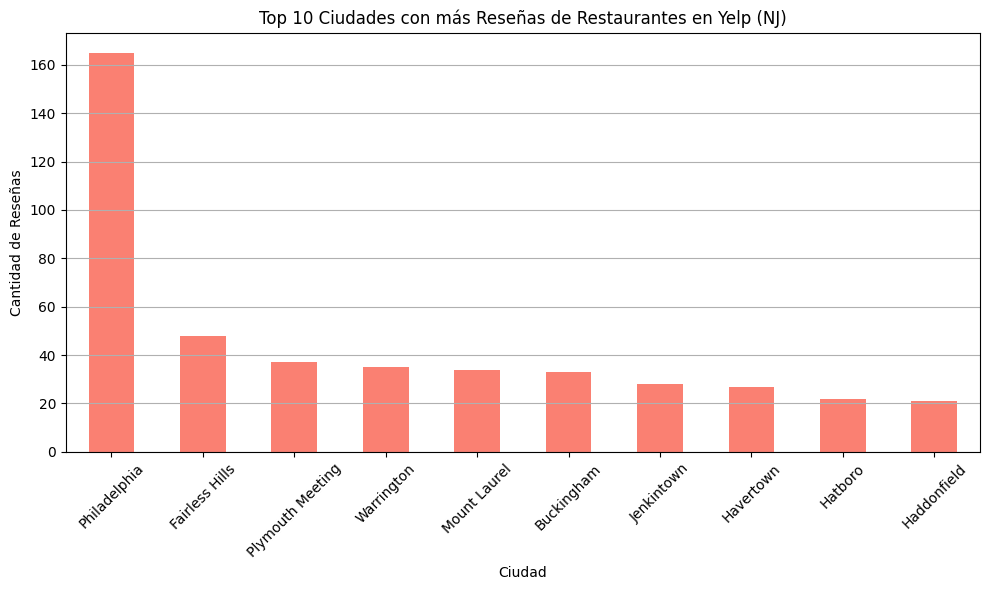

In [48]:
# Filtrar solo los negocios de tipo restaurante
restaurant_ids = yelp_category_rel_df[yelp_category_rel_df['category_id'] == 1]['business_id']

# Filtrar las rese√±as correspondientes
restaurant_reviews = review_yelp_df[review_yelp_df['business_id'].isin(restaurant_ids)].copy()

# Agregar columna 'city' desde yelp_business_df
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y contar rese√±as
top_cities = restaurant_reviews['city'].value_counts().head(10)

# Graficar
plt.figure(figsize=(10,6))
top_cities.plot(kind='bar', color='salmon')
plt.title('Top 10 Ciudades con m√°s Rese√±as de Restaurantes en Yelp (NJ)')
plt.ylabel('Cantidad de Rese√±as')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


üìä 3. Distribuci√≥n de rese√±as por calificaci√≥n (estrellas)

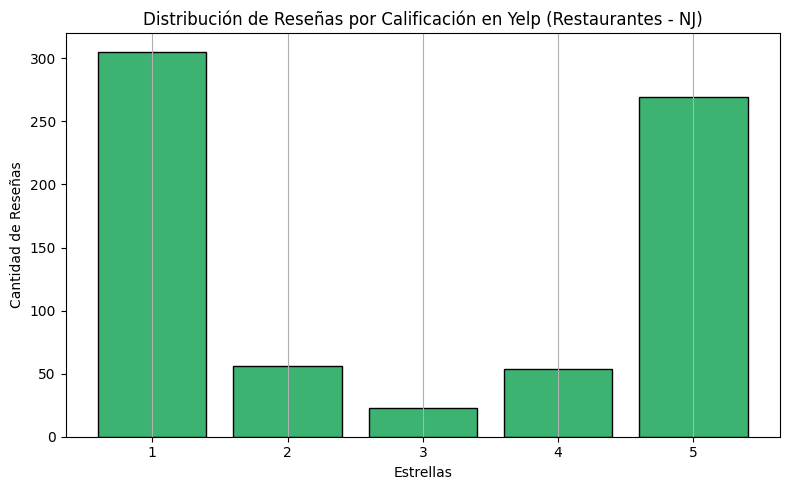

In [49]:
# Histograma de calificaciones de restaurantes (Yelp - NJ)
plt.figure(figsize=(8,5))
restaurant_reviews['stars'].hist(bins=[1, 2, 3, 4, 5, 6], align='left', rwidth=0.8,
                                  color='mediumseagreen', edgecolor='black')

plt.title('Distribuci√≥n de Rese√±as por Calificaci√≥n en Yelp (Restaurantes - NJ)')
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Rese√±as')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


üìä 4. Tendencia temporal de rese√±as de restaurantes

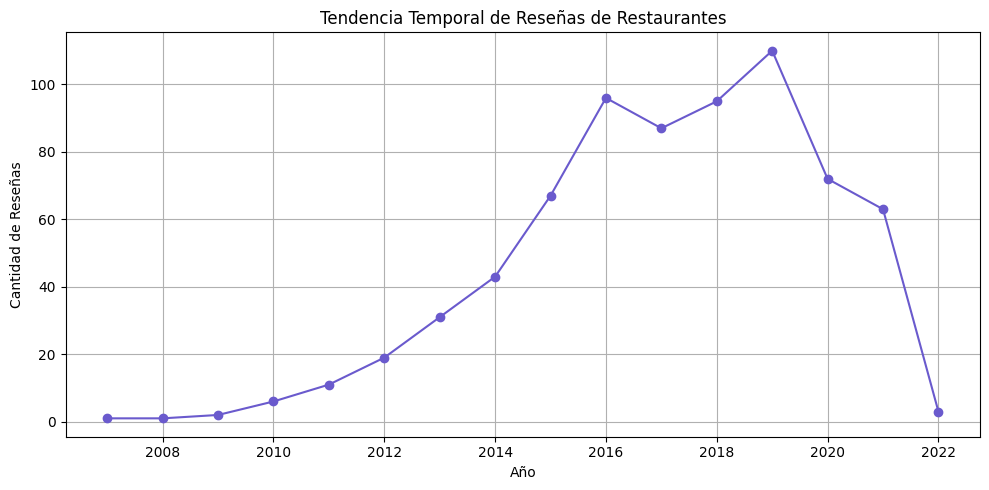

In [50]:
# Agrupar por a√±o
restaurant_reviews['year'] = restaurant_reviews['date'].dt.year
reviews_by_year = restaurant_reviews.groupby('year').size()

# Graficar
plt.figure(figsize=(10,5))
reviews_by_year.plot(marker='o', linestyle='-', color='slateblue')
plt.title('Tendencia Temporal de Rese√±as de Restaurantes')
plt.xlabel('A√±o')
plt.ylabel('Cantidad de Rese√±as')
plt.grid(True)
plt.tight_layout()
plt.show()


üìä 5. Promedio de estrellas por estado (restaurantes)

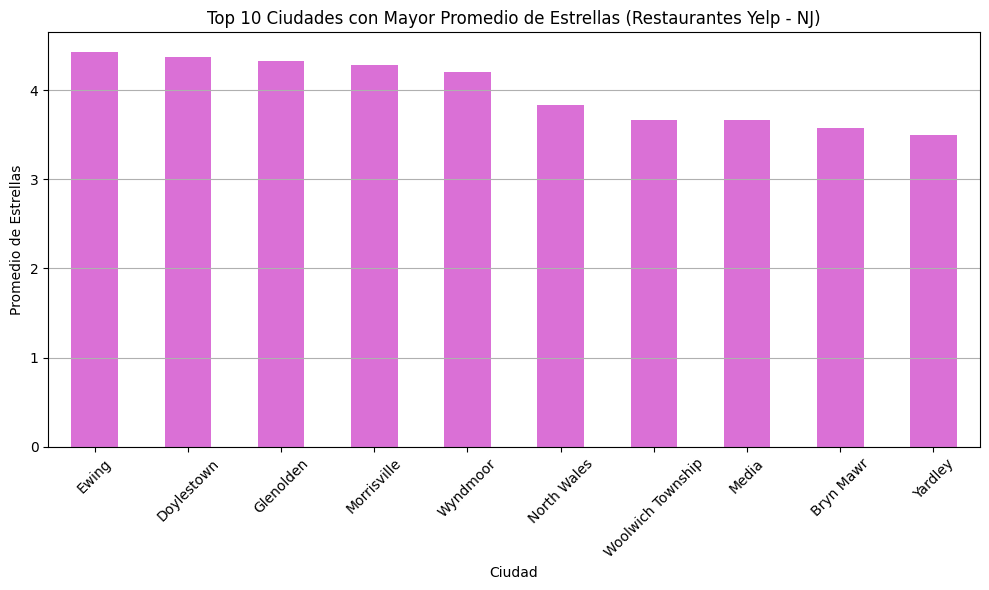

In [51]:
# Asegurar que existe la columna 'city'
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y calcular promedio de estrellas
avg_stars_by_city = restaurant_reviews.groupby('city')['stars'].mean().sort_values(ascending=False).head(10)

# Graficar
plt.figure(figsize=(10,6))
avg_stars_by_city.plot(kind='bar', color='orchid')
plt.title('Top 10 Ciudades con Mayor Promedio de Estrellas (Restaurantes Yelp - NJ)')
plt.ylabel('Promedio de Estrellas')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


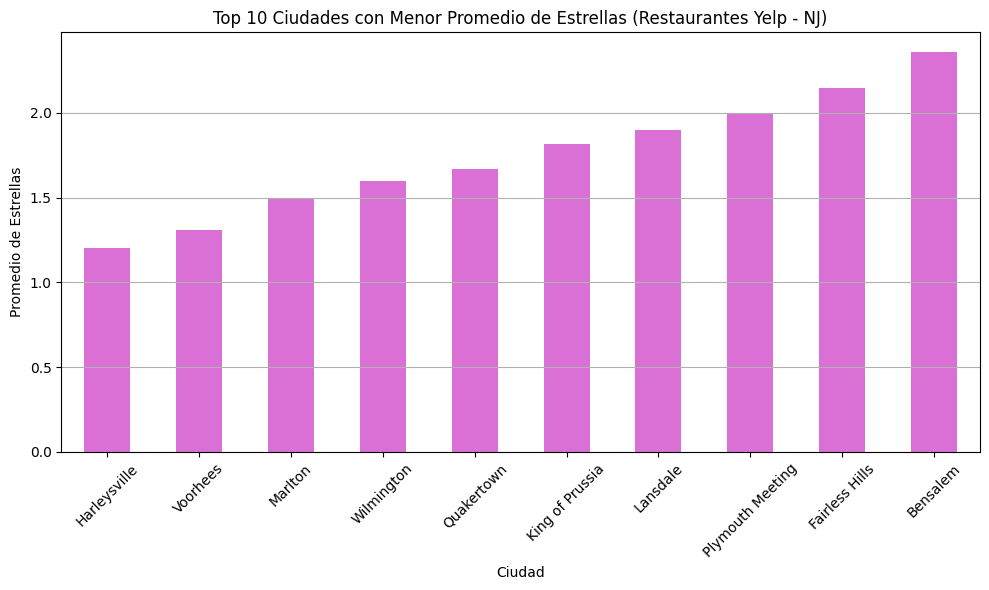

In [52]:
# Asegurar que existe la columna 'city'
city_map = yelp_business_df.set_index('business_id')['city']
restaurant_reviews['city'] = restaurant_reviews['business_id'].map(city_map)

# Agrupar por ciudad y calcular promedio de estrellas
avg_stars_by_city = restaurant_reviews.groupby('city')['stars'].mean().sort_values(ascending=True).head(10)

# Graficar
plt.figure(figsize=(10,6))
avg_stars_by_city.plot(kind='bar', color='orchid')
plt.title('Top 10 Ciudades con Menor Promedio de Estrellas (Restaurantes Yelp - NJ)')
plt.ylabel('Promedio de Estrellas')
plt.xlabel('Ciudad')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Gr√°fico: Categor√≠as con m√°s rese√±as negativas/neutrales en Yelp ---

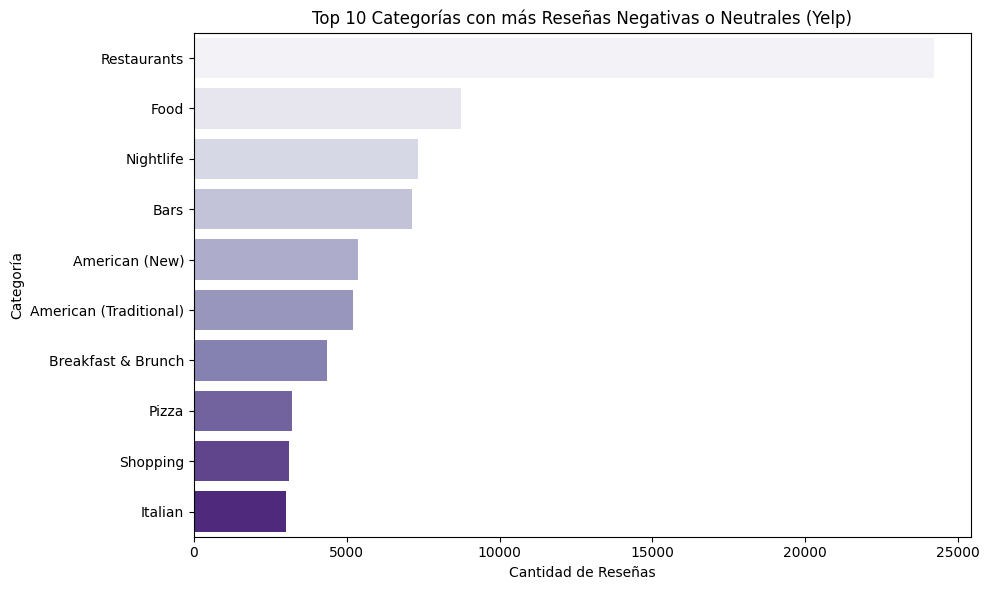

In [61]:
# --- Preparar uni√≥n con categor√≠as ---
query_yelp_category = f"""
SELECT *
FROM `datawave-proyecto-final.yelpdataset.yelp_category`
LIMIT {QUERY_LIMIT}
"""
yelp_category_df = client_us.query(query_yelp_category).to_dataframe()

yelp_business_categories_df = yelp_business_df.merge(
    yelp_category_rel_df,
    on='business_id',
    how='left'
).merge(
    yelp_category_df,
    on='category_id',
    how='left'
)[['business_id', 'name', 'stars', 'category_name']]

# --- Gr√°fico: Categor√≠as con m√°s rese√±as negativas/neutrales en Yelp ---

# 1. Filtrar rese√±as con puntuaci√≥n negativa o neutral (<= 3 estrellas)
yelp_neg_neutral_reviews = review_yelp_df[review_yelp_df['stars'] <= 3]

# 2. Unir rese√±as con las categor√≠as
yelp_reviews_with_cat = yelp_neg_neutral_reviews.merge(
    yelp_business_categories_df,
    on='business_id',
    how='left'
)

# 3. Contar cu√°ntas rese√±as hay por categor√≠a
yelp_cat_counts = yelp_reviews_with_cat['category_name'].value_counts().head(10)

# 4. Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=yelp_cat_counts.values,
    y=yelp_cat_counts.index,
    hue=yelp_cat_counts.index,  # Para que palette funcione bien
    palette='Purples',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categor√≠as con m√°s Rese√±as Negativas o Neutrales (Yelp)')
plt.xlabel('Cantidad de Rese√±as')
plt.ylabel('Categor√≠a')
plt.tight_layout()
plt.show()


# --- Gr√°fico: Categor√≠as con m√°s rese√±as negativas/neutrales en Google Maps ---

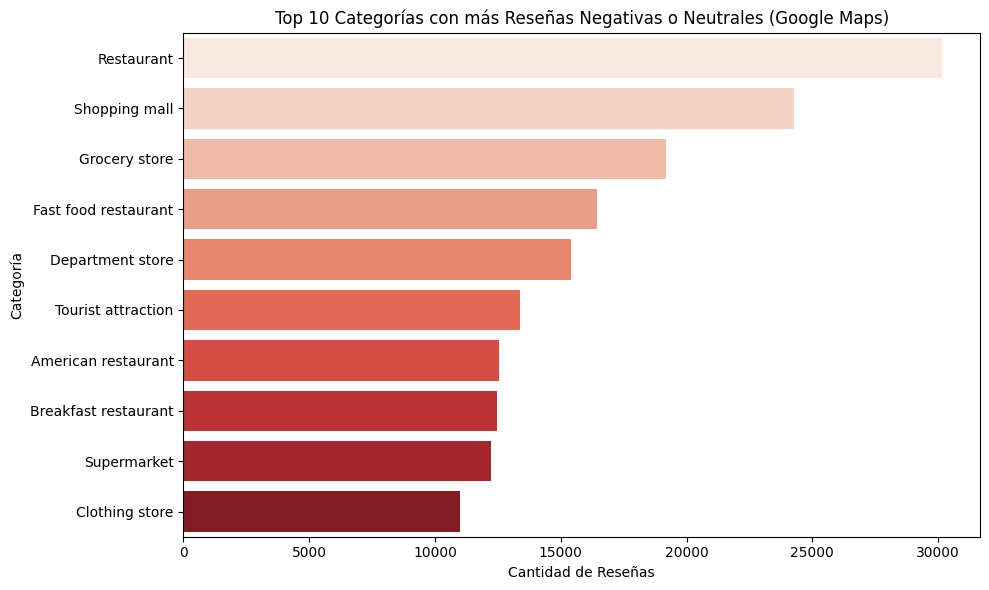

In [64]:
# --- Gr√°fico: Categor√≠as con m√°s rese√±as negativas/neutrales en Google Maps ---

# Filtrar rese√±as negativas o neutrales
gmap_neg_neutral_reviews = review_gmap_df[
    review_gmap_df['sentiment_label'].isin(['negative', 'neutral'])
]

# Unir con categor√≠as
gmap_reviews_with_cat = gmap_neg_neutral_reviews.merge(
    gmap_sites_categories_df[['gmap_id', 'category_name']],
    left_on='gmap_id', right_on='gmap_id', how='left'
)

# Contar por categor√≠a
gmap_cat_counts = gmap_reviews_with_cat['category_name'].value_counts().head(10)

# Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=gmap_cat_counts.values,
    y=gmap_cat_counts.index,
    hue=gmap_cat_counts.index,  # expl√≠cito
    palette='Reds',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categor√≠as con m√°s Rese√±as Negativas o Neutrales (Google Maps)')
plt.xlabel('Cantidad de Rese√±as')
plt.ylabel('Categor√≠a')
plt.tight_layout()
plt.show()


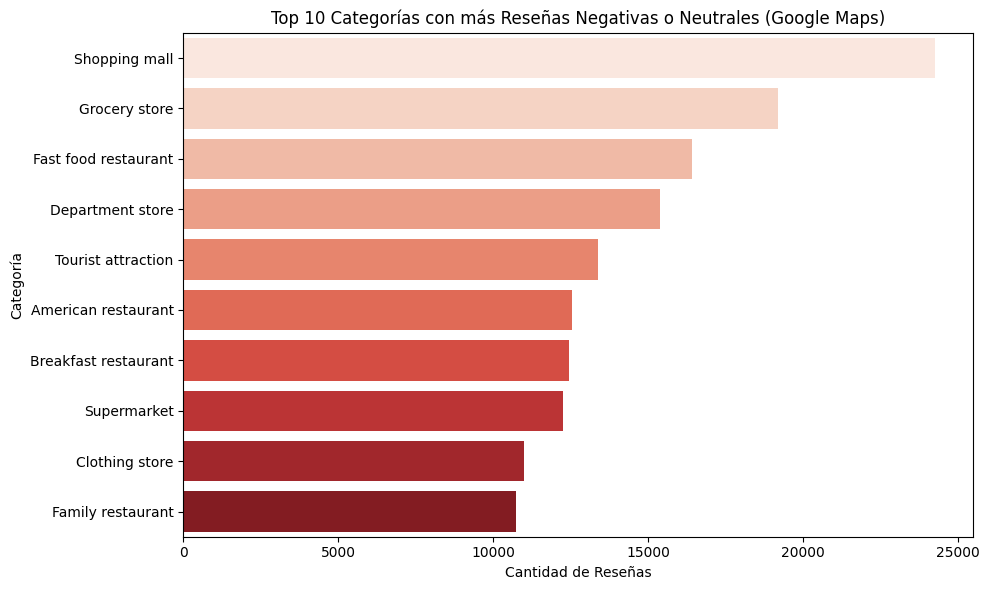

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming review_gmap_df and gmap_sites_categories_df are already defined.
# If not, you'll need to load them first.
# For example:
# review_gmap_df = pd.read_csv('path/to/your/review_gmap_data.csv')
# gmap_sites_categories_df = pd.read_csv('path/to/your/gmap_sites_categories_data.csv')


# Filtrar rese√±as negativas o neutrales
gmap_neg_neutral_reviews = review_gmap_df[
    review_gmap_df['sentiment_label'].isin(['negative', 'neutral'])
]

# Unir con categor√≠as
gmap_reviews_with_cat = gmap_neg_neutral_reviews.merge(
    gmap_sites_categories_df[['gmap_id', 'category_name']],
    left_on='gmap_id', right_on='gmap_id', how='left'
)

# Contar por categor√≠a y seleccionar del 2do al 11vo
# .value_counts() ordena de forma descendente por defecto.
# .iloc[1:11] selecciona los elementos desde el √≠ndice 1 (el segundo) hasta el 10 (el und√©cimo).
gmap_cat_counts = gmap_reviews_with_cat['category_name'].value_counts().iloc[1:11]

# Graficar
plt.figure(figsize=(10,6))
sns.barplot(
    x=gmap_cat_counts.values,
    y=gmap_cat_counts.index,
    hue=gmap_cat_counts.index,   # expl√≠cito
    palette='Reds',
    dodge=False,
    legend=False
)
plt.title('Top 10 Categor√≠as con m√°s Rese√±as Negativas o Neutrales (Google Maps)')
plt.xlabel('Cantidad de Rese√±as')
plt.ylabel('Categor√≠a')
plt.tight_layout()
plt.show()